# Image Classification of ATLAS Calorimeter Topo-Clusters (Jan)

This is a stripped-down version of Max's re-write of his classifier training notebook, so I have removed *some* functionality like ROC curve scans. These could be added back in the future (using the code from his notebooks, maybe put into our library).

In [1]:
source = 'pion'
subdir = 'pion1' # name for subdir holding models/plots

# If true, force re-training even if a model already exists. Existing model will be lost!
overwriteModel = False

# If true, continue training and try to train to the last specified epoch.
# If EarlyStopping was used, this may result in trying to further train a "finished" network.
finishTraining = False

drawPlots = True

# If no file extension, uses native TensorFlow format (.tf).
# If 'h5', uses HDF5. HDF5 does not work for custom layers/classes! (unless you design them a certain way)
file_extension = '.h5'
if(file_extension != '' and '.' not in file_extension):
    file_extension = '.' + file_extension

## Quick Navigation:
- [Simple feed-forward Neural Network](#Simple-feed-forward-Neural-Network)
- [Combination Network](#Combination-Network)
- [Convolutional Neural Networks](#Convolutional-Neural-Networks)
    - [Single-calo-layer CNN](#Single-calo-layer-CNN's)
    -[Combination Network (CNN's)](#Combination-Network:-Take-2)
    - [Complex CNN's](#Convolutional-Neural-Networks:-More-complicated-architectures)
        - [3 EMB layers, separate](#3-EMB-layers,-separate)
        - [All layers, separate](#All-layers,-separate)
        - [All layers, merged](#All-layers,-merged)
        - [EMB merged + TileBar merged](#EMB-merged-+-TileBar-merged)
        - [EMB merged + TileBar depth](#EMB-merged-+-TileBar-depth)
        - [EMB1 + (EMB2+EMB3) + TileBar merged](#EMB1,-EMB2+EMB3,-and-TileBar)
- [ResNet](#ResNet)
- [Combination Network (ResNet + simple NN)](#Combination-Network:-Take-3)

- [Summary Plots](#Summary-Plots)

In [2]:
#import libraries and some constants
import os, sys, json, pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT as rt # I will use this for some plotting
import uproot as ur

path_prefix = os.getcwd() + '/../'
plotpath = path_prefix+'classifier/Plots/{}/'.format(subdir)
modelpath = path_prefix+'classifier/Models/{}/'.format(subdir)

for dir in [plotpath,modelpath]:
    try:os.makedirs(dir)
    except: pass

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
from util import qol_util as qu

# Custom tensorflow.keras callbacks
from util.keras.callbacks import GetCallbacks

# Classification-specific utils
from util.classification import training_util as ctu
from util.classification import plot_util as cpu
from util.classification import data_util as cdu

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/00


In [3]:
# fancy display names for each pion type
pi_latex = {
    'p0': '\(\pi^{0}\)',
    'pp': '\(\pi^{\pm}\)',
}
pi_text = {
    'p0': 'pi0',
    'pp': 'pi+/-'
}

# Plotting settings
# xkcd -- turn this on for fun-looking (but marginally less useful) plots
use_xkcd = False
if(use_xkcd):
    mode = 'light'
    plt.xkcd(scale=.75,length=100,randomness=1)
    
# plotting style -- manages our color palette and object colors
mode = 'dark' # for publications, use "light"
plotstyle = qu.PlotStyle(mode)
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

Now, we will import our data from the `ROOT` files.

In [4]:
if(source == 'pion_legacy'):
    inputpath = path_prefix+'data/pion_legacy/'
    rootfiles = {
        'p0':inputpath + 'pi0.root',
        'pp':inputpath + 'pi[pm]*.root'
    }
    branches = [
                'clusterE', 'clusterECalib', 
                'clusterPt', 'clusterEta', 'clusterPhi', 
                'cluster_nCells', 'cluster_sumCellE', 
                'cluster_ENG_CALIB_TOT', 'cluster_EM_PROBABILITY'
    ]

elif(source == 'pion'):
    inputpath=path_prefix+'data/pion/'
    rootfiles = {        
        'p0':inputpath + 'user.mswiatlo.900246.PG_singlepi0_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root',
        'pp':inputpath + 'user.mswiatlo.900247.PG_singlepion_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root'
    }
    branches = [
                'clusterE', 'clusterECalib', 
                'clusterPt', 'clusterEta', 'clusterPhi', 
                'cluster_nCells', 'cluster_sumCellE', 
                'cluster_ENG_CALIB_TOT', 'cluster_EM_PROBABILITY'
    ]    

elif(source == 'pion_converted'):
    inputpath = path_prefix+'data/pion_converted/'
    rootfiles = {
        'p0':inputpath + 'user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/*.root',
        'pp':inputpath + 'user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/*.root'
    }
    branches = [
        'cluster_E', 'cluster_E_LCCalib', 
        'cluster_Pt', 'cluster_Eta', 'cluster_Phi', 
        'cluster_nCells',
        'cluster_ENG_CALIB_TOT', 'cluster_EM_PROBABILITY'
    ]
    
else: assert(False)

In [5]:
# Prepare data
h5_name_suffix = 'tdata'
h5_name = inputpath + h5_name_suffix

pdata,pcells = mu.setupPionData(
    rootfiles, 
    branches=branches, 
    layers=layers, 
    balance_data=True, 
    n_max = 300000,
    verbose=True,
    load=True,
    save=True,
    filename=h5_name,
    match_distribution='cluster_ENG_CALIB_TOT',
    match_binning = (20000,0.,2000.),
    cut_distributions=['cluster_ENG_CALIB_TOT','clusterEta'],
    cut_values = [.2, (-0.7,0.7)],
    cut_types=['lower','window']
)

total = np.sum([len(x) for x in pdata.values()],dtype=int)
for key,frame in pdata.items():
    n = len(frame)
    print("Number of {a:<7} events: {b:>10}\t({c:.1f}%)".format(a=pi_text[key], b = n, c = 100. * n / total))
print("Total: {}".format(total))

pdata_merged, pcells_merged, plabels = cdu.DataPrep(pdata, 
                                                    pcells, 
                                                    layers, 
                                                    trainfrac=0.7,
                                                    filename=h5_name
                                                   )

Loading pandas DataFrame and calo images from /local/home/jano/ml4pions/LCStudies/classifier/../data/pion_legacy/tdata_frame.h5 and /local/home/jano/ml4pions/LCStudies/classifier/../data/pion_legacy/tdata_images.h5.
Number of pi0     events:     259590	(50.0%)
Number of pi+/-   events:     259590	(50.0%)
Total: 519180
Loading indices for key p0 from /local/home/jano/ml4pions/LCStudies/classifier/../data/pion_legacy/tdata_indices.h5.
Loading indices for key pp from /local/home/jano/ml4pions/LCStudies/classifier/../data/pion_legacy/tdata_indices.h5.


We'll train the network on $\pi^+$ and $\pi^0$ events.

### Plot a few example images.

These are the images that we will use to train our network (together with a few other variables).

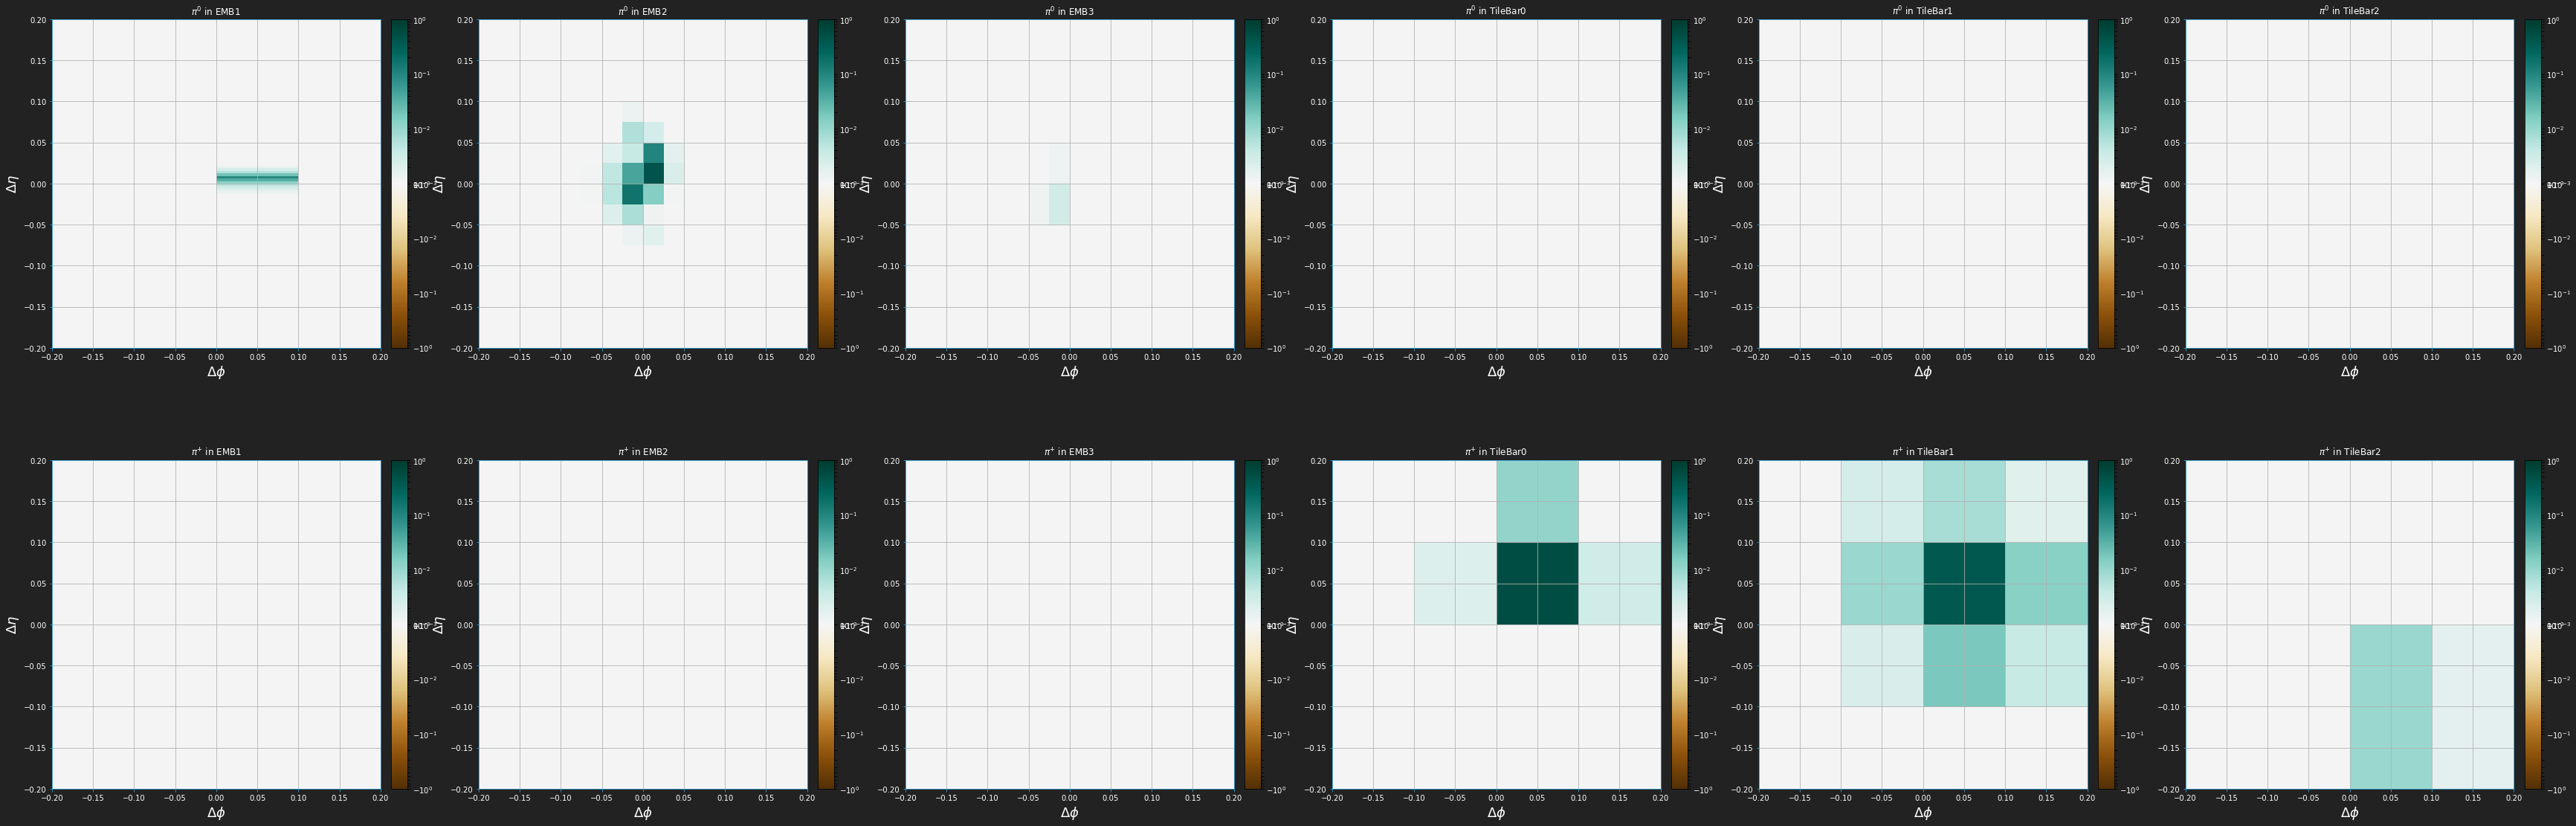

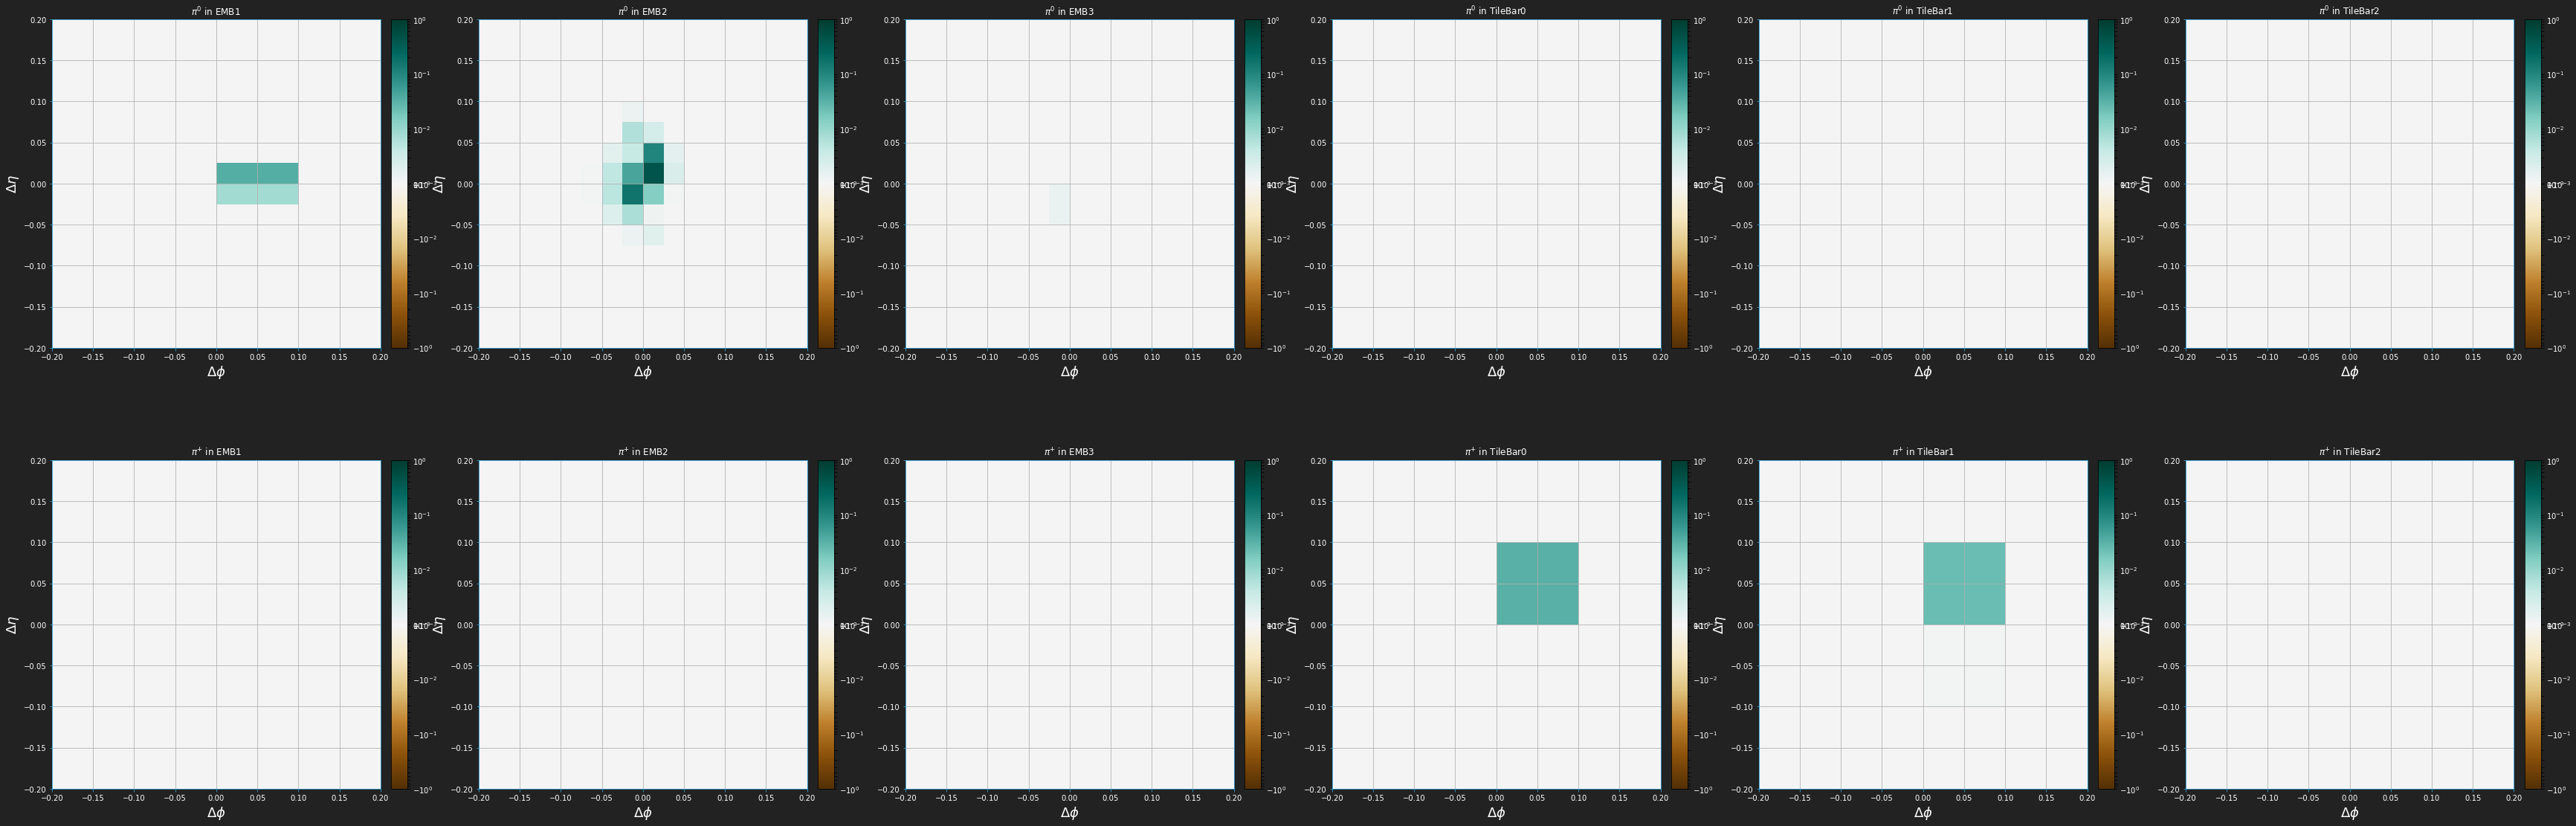

In [6]:
cluster_idx = 50 # pick a cluster from our dataset to draw
cpu.ImagePlot(
    pcells,
    cluster=cluster_idx,
    layers=layers,
    cell_shapes=cell_shapes,
    plotpath=plotpath,
    filename='calo_images.png',
    plotstyle=plotstyle
)

scaled_shape = (16,16)
cpu.ImagePlot(
    pcells,
    cluster=cluster_idx,
    scaled_shape=scaled_shape,
    layers=layers,
    cell_shapes=cell_shapes,
    plotpath=plotpath,
    filename='calo_images_{}x{}.png'.format(*scaled_shape),
    plotstyle=plotstyle
)

### Plot a few histograms.

These are a bit uglier than the `matplotlib` ones Max made, but it's perhaps even easier to see any differences between $\pi^\pm$ and $\pi^0$.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/classifier/../classifier/Plots/pion1/hist_pi0_plus_minus.png has been created


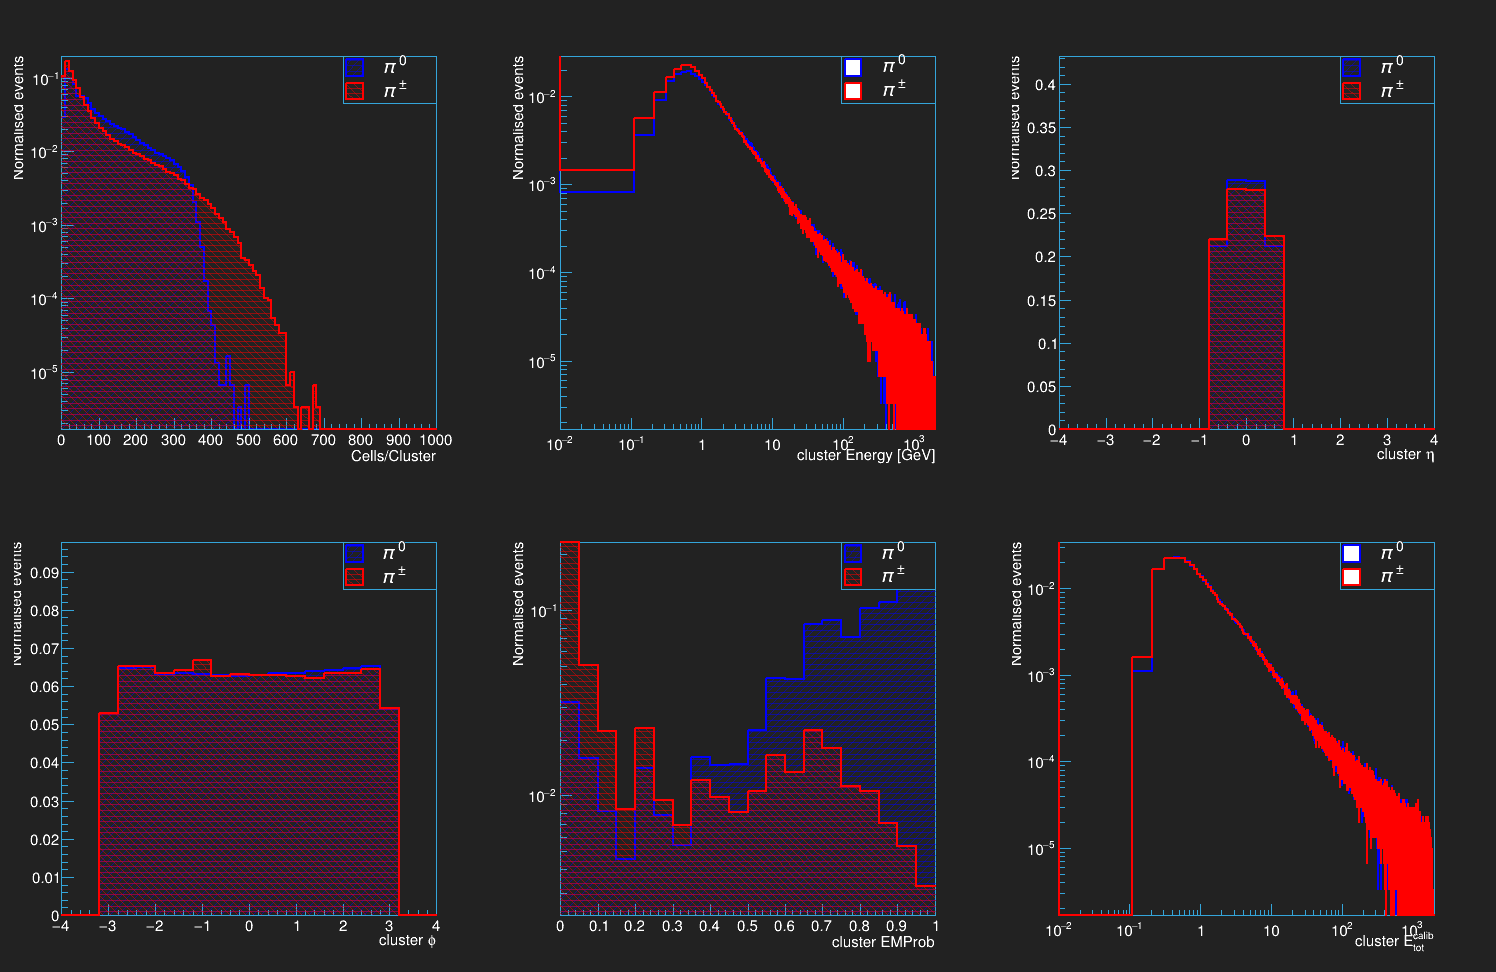

In [7]:
rt.gStyle.SetOptStat(0)
plotstyle.SetStyle()

#if(drawPlots):
# For storing histograms and legends, to prevent overwriting. (TODO: Probably better ways to do this in PyROOT)
histos = []
legends = []

# Exhaustive list of quantities we want to plot. Note that some will not be available, depending on dataset provenance/age.
n_bins_small = 20
n_bins_med = 100
n_bins_large = int(2e4)
qtys = [
    ('cluster_nCells','Cells/Cluster',(n_bins_med,0,1000)),
    ('clusterE','cluster Energy [GeV]',(n_bins_large,1.0e-2,2.0e3)),
    ('cluster_E','cluster Energy [GeV]',(n_bins_large,1.0e-2,2.0e3)),
    ('clusterEta','cluster #eta',(n_bins_small,-4.,4.)),
    ('cluster_Eta','cluster #eta',(n_bins_small,-4.,4.)),
    ('clusterPhi','cluster #phi',(n_bins_small,-4.,4.)),
    ('cluster_Phi','cluster #phi',(n_bins_small,-4.,4.)),
    ('cluster_EM_PROBABILITY','cluster EMProb',(n_bins_small,0.,1.)),
    #('cluster_sumCellE','cluster SumCellE',(n_bins_small,0.,2500.)),
    ('cluster_ENG_CALIB_TOT','cluster E^{calib}_{tot}',(n_bins_large,1.0e-2,2.0e3))
]

log_x = ['clusterE', 'cluster_E', 'cluster_ENG_CALIB_TOT']
log_y = ['cluster_nCells','clusterE', 'cluster_E', 'cluster_EM_PROBABILITY', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT']

qtys = [x for x in qtys if x[0] in branches]

qty_labels = [x[1] for x in qtys]
qty_ranges = [x[2] for x in qtys]
qtys =       [x[0] for x in qtys]

# Set up a canvas.
plot_size = 500
nx = int(np.ceil(len(qtys) / 2))
ny = 2
n_pad = nx * ny
canvas = rt.TCanvas('cluster_hists','c1',plot_size * nx,plot_size * ny)
canvas.Divide(nx,ny)

colors = {'pp':rt.kRed,'p0':rt.kBlue}
styles = {'pp':3440, 'p0':3404}

n_bins=20
for i, (qty, label, rng) in enumerate(zip(qtys, qty_labels, qty_ranges)):
    canvas.cd(i+1)
    leg = rt.TLegend(0.7,0.8,0.9,0.9)
    for ptype, p in pdata.items():
        hist = rt.TH1F('h_'+str(ptype)+'_'+str(qty),'',rng[0],rng[1],rng[2])
        for entry in p[qty]: hist.Fill(entry)
        integral = hist.Integral()
        if(integral != 0): hist.Scale(1./hist.Integral())
        hist.SetLineColor(colors[ptype])
        hist.SetLineWidth(2)

        if(qty not in log_x):
            hist.SetFillColorAlpha(colors[ptype],0.5)
            hist.SetFillStyle(styles[ptype])

        hist.Draw('HIST SAME')
        hist.GetXaxis().SetTitle(label)
        hist.GetYaxis().SetTitle('Normalised events')
        hist.SetMaximum(1.5 * hist.GetMaximum())
        leg.AddEntry(hist,pi_latex[ptype],'f')
        leg.Draw()
        histos.append(hist)
        legends.append(leg)

    if(qty in log_x): rt.gPad.SetLogx()
    if(qty in log_y): rt.gPad.SetLogy()
canvas.Draw()

canvas.SaveAs(plotpath+'hist_pi0_plus_minus.png')

## TensorFlow/Keras prep

**Note:** Starting in May 2021, I've run into some issues with `tensorflow`/`tensorflow-gpu` not detecting/using GPU's. This issue is documented in a number of places, including [here](https://github.com/ContinuumIO/anaconda-issues/issues/12194). The current fix is to use an older version of `tensorflow` (and downgrading things is seldom a satisfying solution).

You can check GPU usage using `nvidia-smi`. Note that it appears to immediately show a python process using memory after running the setup cell below. Once training begins, you can check that this is actually being used by monitoring power consumption and volatile GPU memory usage (which should increase noticeably once you start actual training). TensorFlow may still print out info about broadcasting things to CPU, which by itself isn't an issue or sign that the GPU is not being used.

In [8]:
ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
#gpu_list = ["/gpu:0"] #["/gpu:0","/gpu:1","/gpu:2","/gpu:3"]

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=gpu_list) # if running into issues, see https://stackoverflow.com/questions/54766621/mirroredstrategy-doesnt-use-gpus
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))
from util.classification.models import baseline_nn_model, baseline_cnn_model, emb_cnn_model, all_cnn_model, merged_cnn_model, merged_cnn_2p_model, resnet, simple_combine_model
from util.classification.models_exp import exp_cnn_model, exp_merged_model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


Let's prepare some callbacks (originally from our regression notebook).

In [9]:
# For storing models and some of their metrics (acc, loss)
models = {}
model_history = {}
model_scores = {}
model_performance = {}

# For storing info on ROC curves
roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

Let's add some info to our dictionaries that corresponds to the existing `EM LC Prob` method.

In [10]:
model_key = 'LC EMProb'
model_scores[model_key] = 1-pdata_merged["cluster_EM_PROBABILITY"]
cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    drawPlots=False
)

Area under curve for LC EMProb: 0.9408900906944444


## Simple feed-forward Neural Network
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>

First, we're going to train simple, feed-foward neural networks -- one per calo layer. These will be our "baseline networks".

Note that while for most of the notebook, we'll train one instance of a network per model, whereas here we will explicitly train multiple instances as we're doing one instance *per calo layer*, each for the same model.

In [11]:
lr = 5e-5
gamma = 0.1
min_delta = 0.0001
patience = 3
dropout = 0.1 # < 0 -> no dropout
normalization = True # normalize calo images to unit integral

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts

model_name = 'flat'
model_dir = modelpath + model_name # directory for loading/saving flat models

for layer in layers:
    
    model_key = '{}_{}'.format(model_name, layer)
    modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
    npix = cell_shapes[layer][0] * cell_shapes[layer][1]
    models[model_key] = baseline_nn_model(strategy, npix, lr=lr, dropout=dropout, normalization=normalization)
    
    # train the network
    models[model_key], model_history[model_key] = ctu.TrainNetwork(
        model=models[model_key], 
        modelfile=modelfile, 
        x_train = pcells_merged[layer][pdata_merged.train], 
        y_train = plabels[pdata_merged.train], 
        x_valid = pcells_merged[layer][pdata_merged.val], 
        y_valid = plabels[pdata_merged.val], 
        callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
        epochs=nepochs, 
        batch_size=batch_size, 
        verbose=verbose, 
        overwriteModel=overwriteModel,
        finishTraining=finishTraining
    )
        
    # get performance metric from test set
    model_performance[model_key] = models[model_key].evaluate(
        pcells_merged[layer][pdata_merged.test],
        plabels[pdata_merged.test],
        verbose=0
    )
    
    print('Finished layer {}.'.format(layer))
    
    # get/recalculate network scores for the dataset
    model_scores[model_key] = models[model_key].predict(pcells_merged[layer])[:,1]

Finished layer EMB1.
Finished layer EMB2.
Finished layer EMB3.
Finished layer TileBar0.
Finished layer TileBar1.
Finished layer TileBar2.


Let's look at accuracy and loss, as well as ROC curves, for each network.

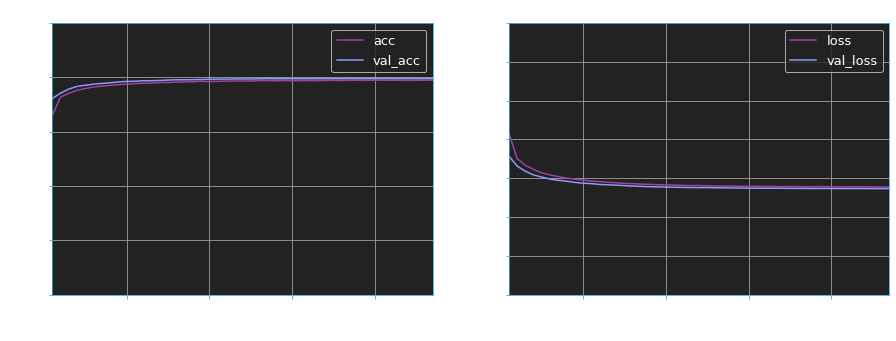

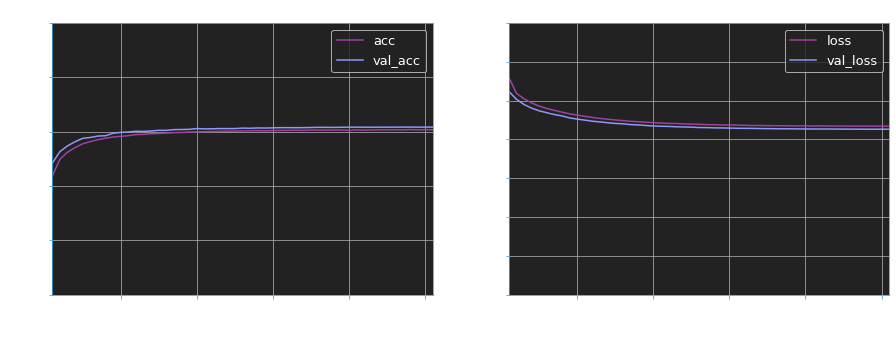

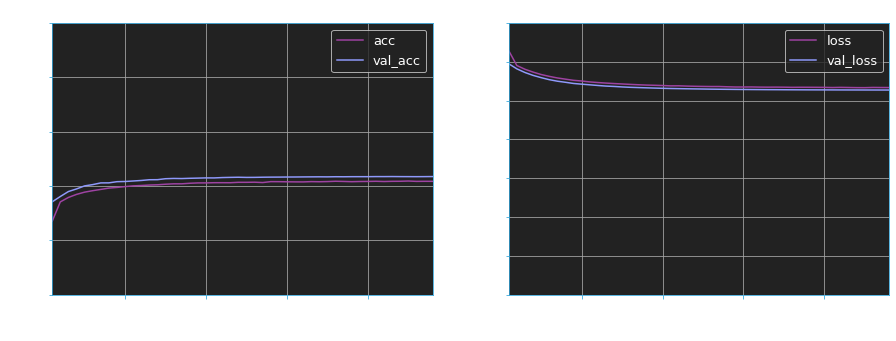

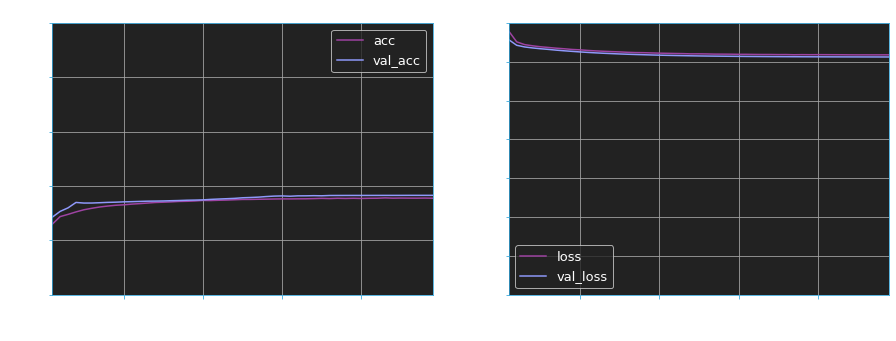

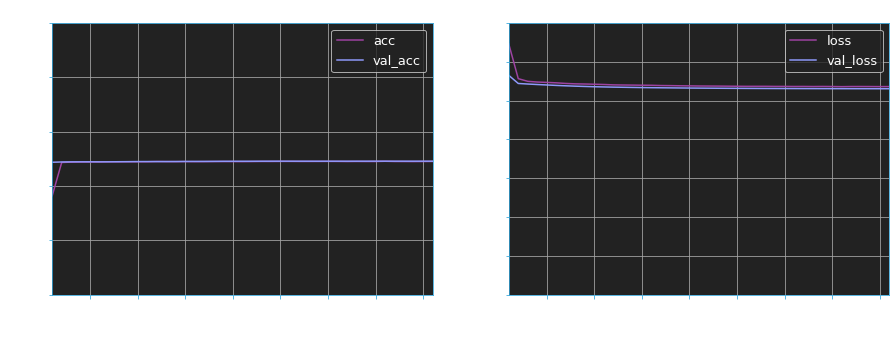

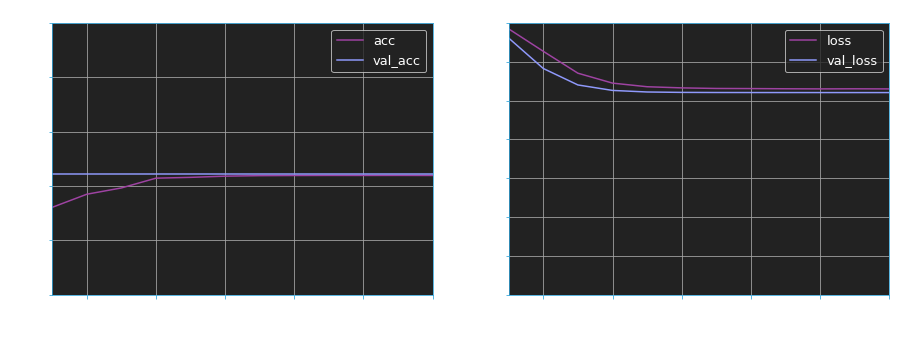

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for flat_EMB1: 0.9523438956944446
Area under curve for flat_EMB2: 0.87490145
Area under curve for flat_EMB3: 0.7975528063888888
Area under curve for flat_TileBar0: 0.7018367758333335
Area under curve for flat_TileBar1: 0.7639063586111112
Area under curve for flat_TileBar2: 0.7225412204166666


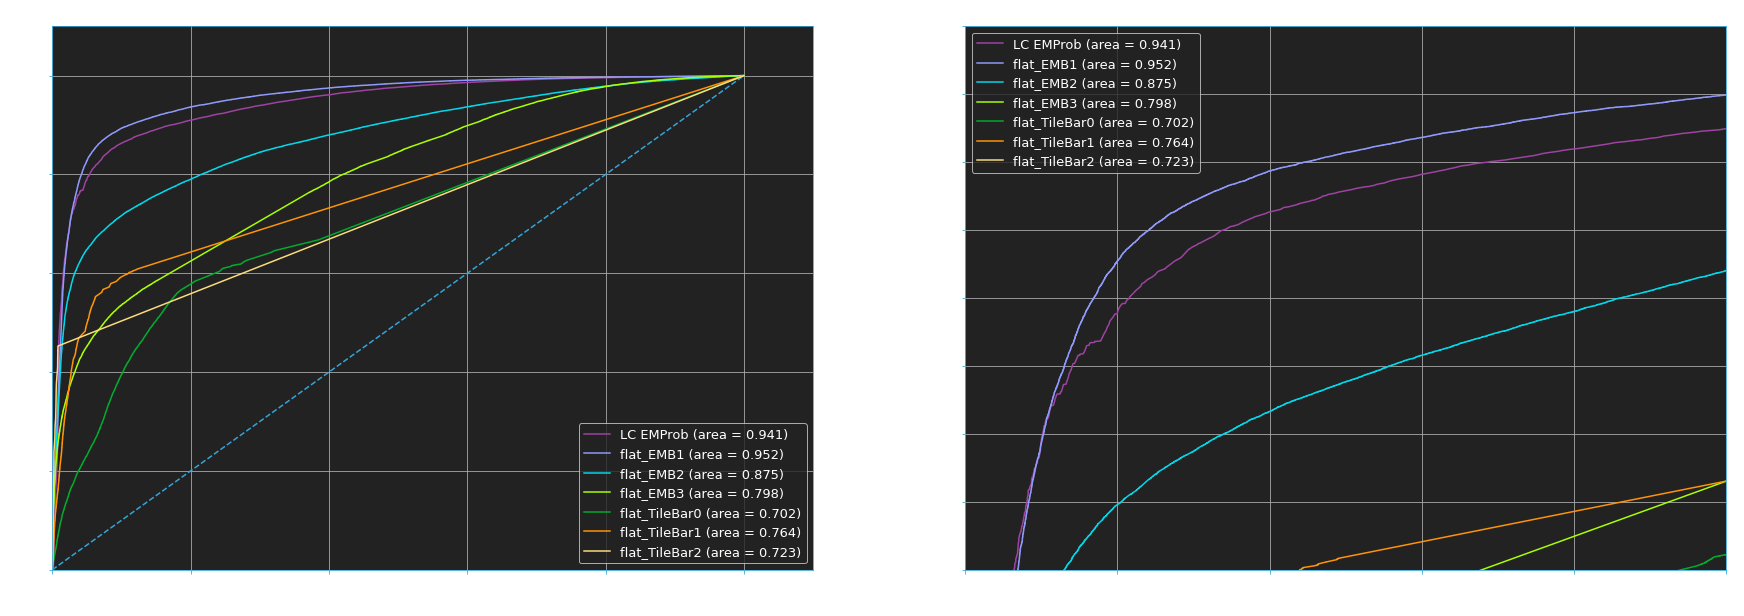

In [12]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_flat',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10)
)

## Combination Network
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>

Here we train a simple combination network. Its inputs will be the *outputs* of our simple, feed-forward neural networks from above.

In [13]:
model_name = 'simple'
model_dir = modelpath + model_name # directory for loading/saving simple combination network
model_key = 'simpleCombine'

model_scores_stack = np.column_stack( [model_scores['flat_{}'.format(layer)] for layer in layers])
n_input = model_scores_stack.shape[1]

lr = 1e-3
gamma = 0.1
min_delta = 0.0005
patience = 5

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key,file_extension)
models[model_key] = simple_combine_model(strategy, lr=lr, n_input=n_input)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = model_scores_stack[pdata_merged.train],
    y_train = plabels[pdata_merged.train], 
    x_valid = model_scores_stack[pdata_merged.val], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    model_scores_stack[pdata_merged.test],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(model_scores_stack)[:,1]

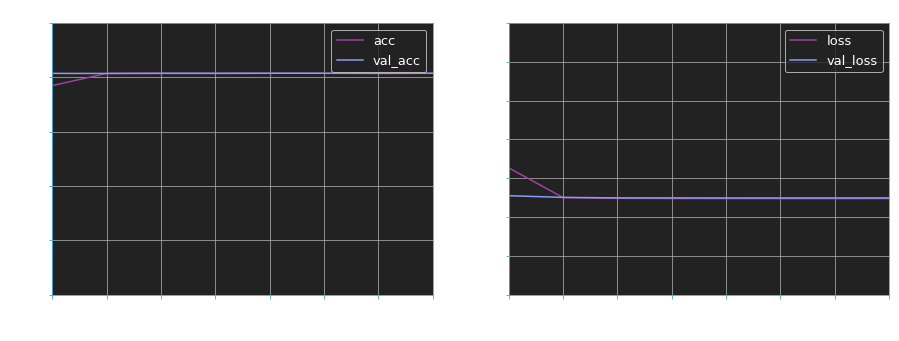

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for flat_EMB1: 0.9523438956944446
Area under curve for simpleCombine: 0.9616348475


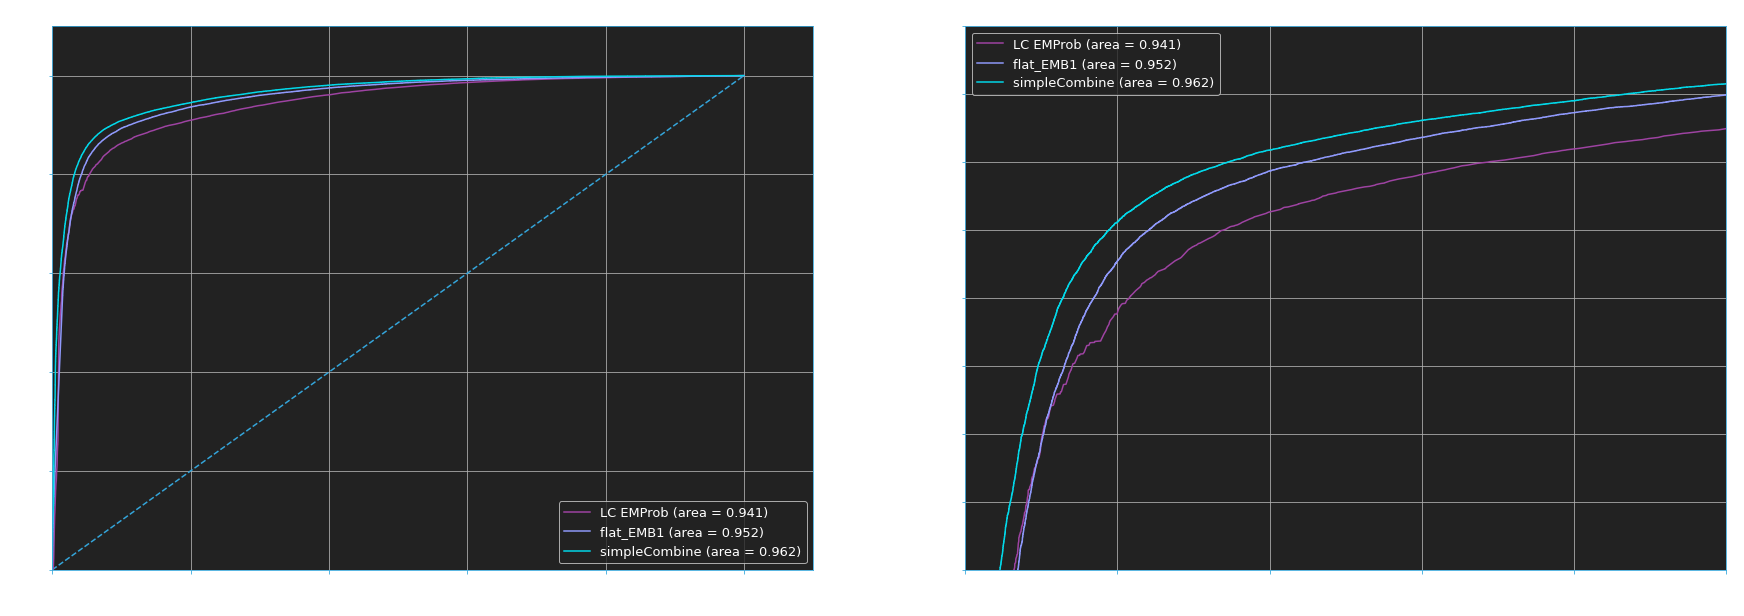

In [14]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys = ['simpleCombine'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_simple',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = ['LC EMProb', 'flat_EMB1', 'simpleCombine']
)

## Convolutional Neural Networks
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
Let's try some convolutional neural networks -- afterwards we'll also try an implementation of ResNet.

In [15]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=True)
rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)

### Single-calo-layer CNN's
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
First up, we can try creating a set of CNN's, where each only uses an image from a single calorimeter layer.

In [16]:
lr = 5e-5
gamma = 0.1
min_delta = 0.0001
patience = 3
augmentation = True
normalization = True # normalize calo images to unit integral
nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts

model_name = 'cnn'
model_dir = modelpath + model_name # directory for loading/saving flat models

filters = {
    'EMB1': (2,4), 
    'EMB2': (4,4), 
    'EMB3': (4,2), 
    'TileBar0': (2,2), 
    'TileBar1': (2,2), 
    'TileBar2': (1,1)
}
pools = {
    'EMB1': (1,1), 
    'EMB2': (2,2), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}

for layer in layers:
    model_key = '{}_{}'.format(model_name, layer)
    modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)    
    models[model_key] = baseline_cnn_model(input_shape=cell_shapes[layer], f=filters[layer], pool=pools[layer], lr=lr, augmentation=augmentation, normalization=normalization)
    
    # train the network
    models[model_key], model_history[model_key] = ctu.TrainNetwork(
        model=models[model_key], 
        modelfile=modelfile, 
        x_train = rn_data['train'][layer], 
        y_train = plabels[pdata_merged.train], 
        x_valid = rn_data['valid'][layer],
        y_valid = plabels[pdata_merged.val], 
        callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
        epochs=nepochs, 
        batch_size=batch_size, 
        verbose=verbose, 
        overwriteModel=overwriteModel,
        finishTraining=finishTraining
    )
        
    # get performance metric from test set
    model_performance[model_key] = models[model_key].evaluate(
        rn_data['test'][layer],
        plabels[pdata_merged.test],
        verbose=0
    )
    
    print('Finished layer {}.'.format(layer))
    
    # get/recalculate network scores for the dataset
    model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened[layer])[:,1]

Finished layer EMB1.
Finished layer EMB2.
Finished layer EMB3.
Finished layer TileBar0.
Finished layer TileBar1.
Finished layer TileBar2.


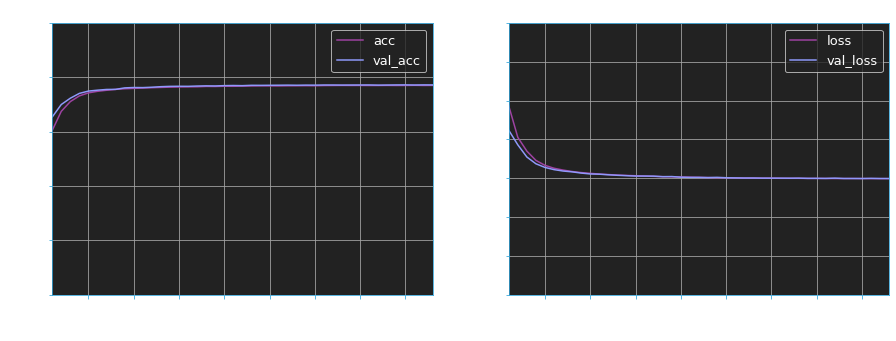

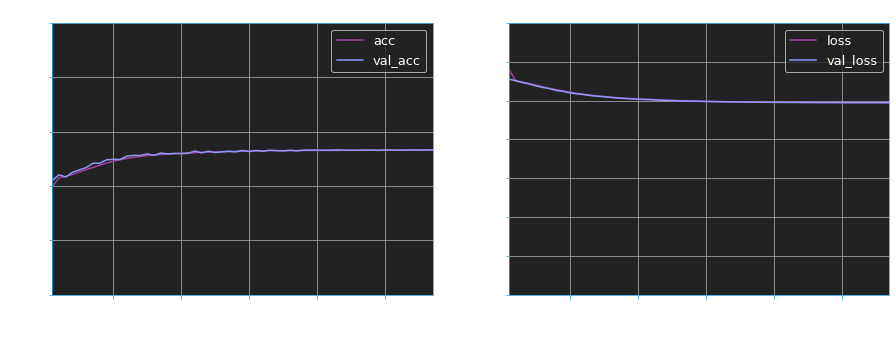

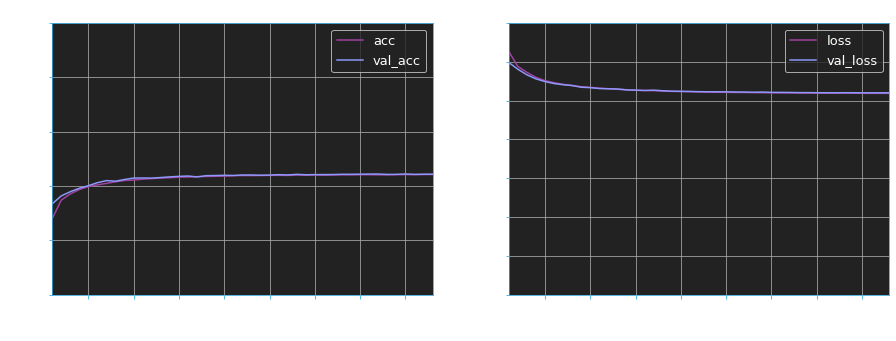

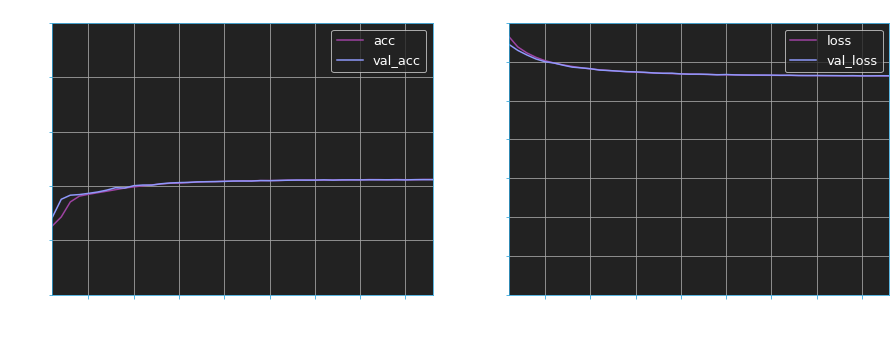

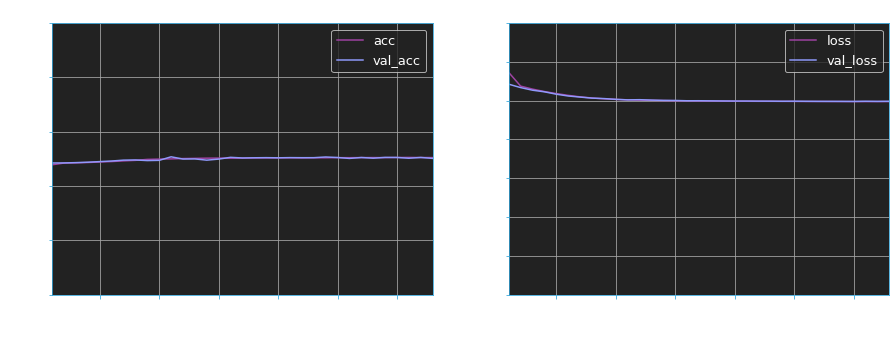

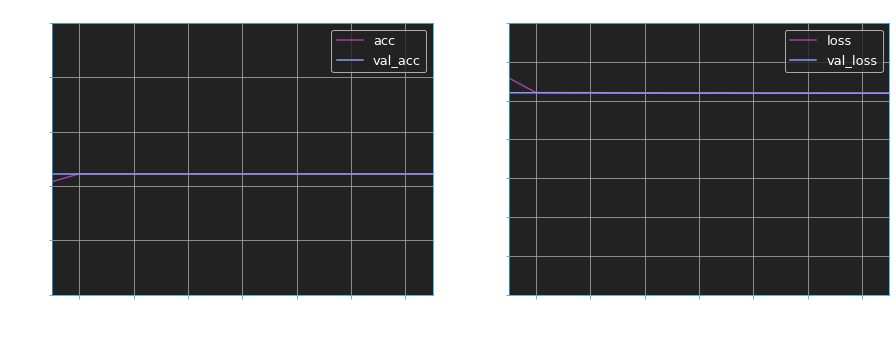

Area under curve for cnn_EMB1: 0.9431524611111113
Area under curve for cnn_EMB2: 0.8210821644444446
Area under curve for cnn_EMB3: 0.8017951770833334
Area under curve for cnn_TileBar0: 0.7453462731944446
Area under curve for cnn_TileBar1: 0.7728231590277778
Area under curve for cnn_TileBar2: 0.7231293838888889


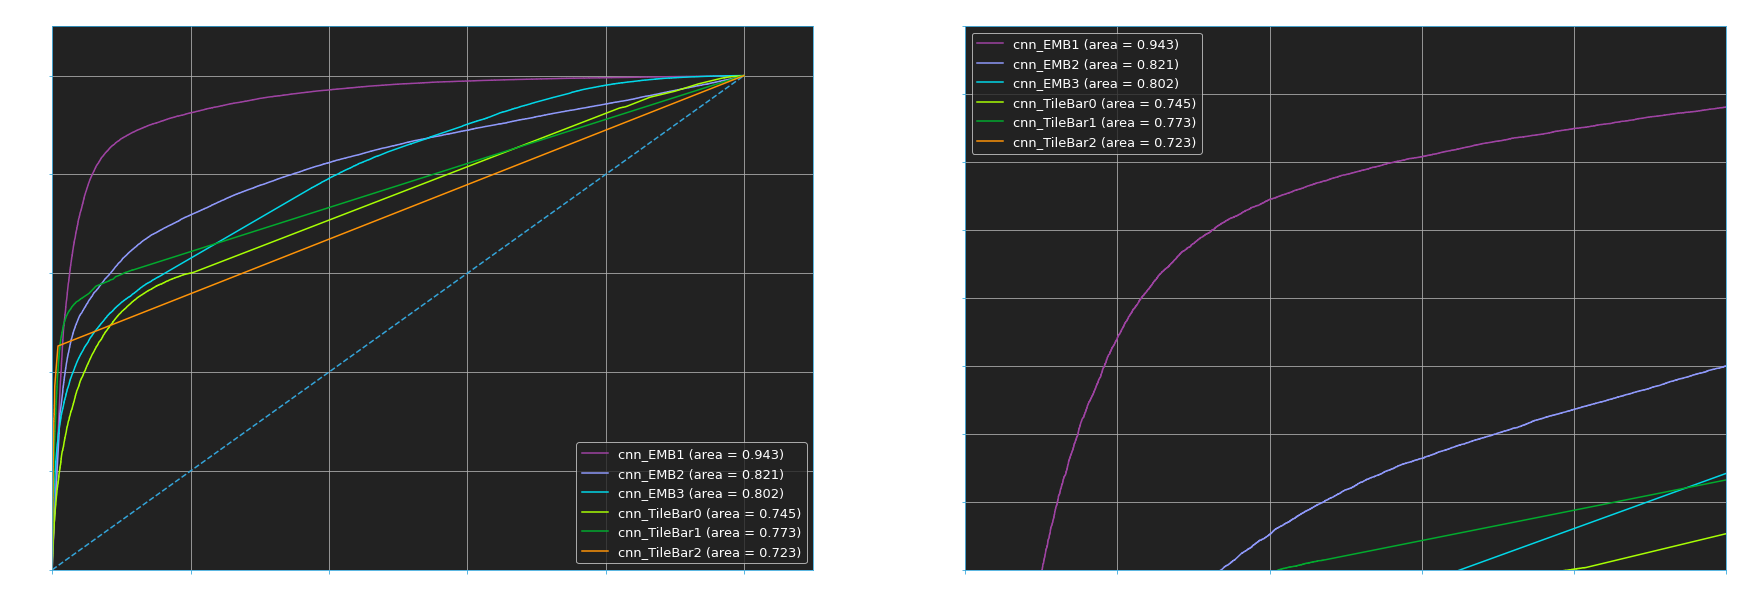

In [17]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    plotstyle=plotstyle,
    model_keys = ['cnn_{}'.format(layer) for layer in layers]
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_cnn',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = ['cnn_{}'.format(layer) for layer in layers]
)

### Combination Network: Take 2
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
Let's try another combination network, using our single layer CNN's.

In [18]:
model_name = 'simple_cnn'
model_dir = modelpath + model_name # directory for loading/saving simple combination network
model_key = 'simpleCombine_cnn'

model_scores_stack = np.column_stack([model_scores['cnn_{}'.format(layer)] for layer in layers])
n_input = model_scores_stack.shape[1]

lr = 1e-3
gamma = 0.1
min_delta = 0.0001
patience = 3

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key,file_extension)
models[model_key] = simple_combine_model(strategy, lr=lr, n_input=n_input)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = model_scores_stack[pdata_merged.train],
    y_train = plabels[pdata_merged.train], 
    x_valid = model_scores_stack[pdata_merged.val], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    model_scores_stack[pdata_merged.test],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(model_scores_stack)[:,1]

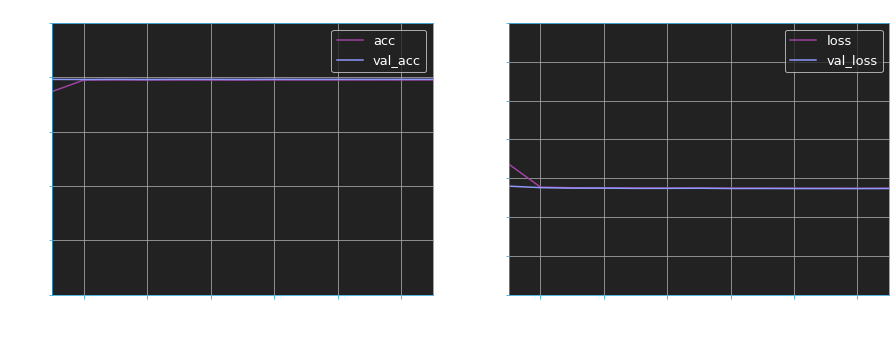

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for simpleCombine: 0.9616348475
Area under curve for simpleCombine_cnn: 0.9543338475


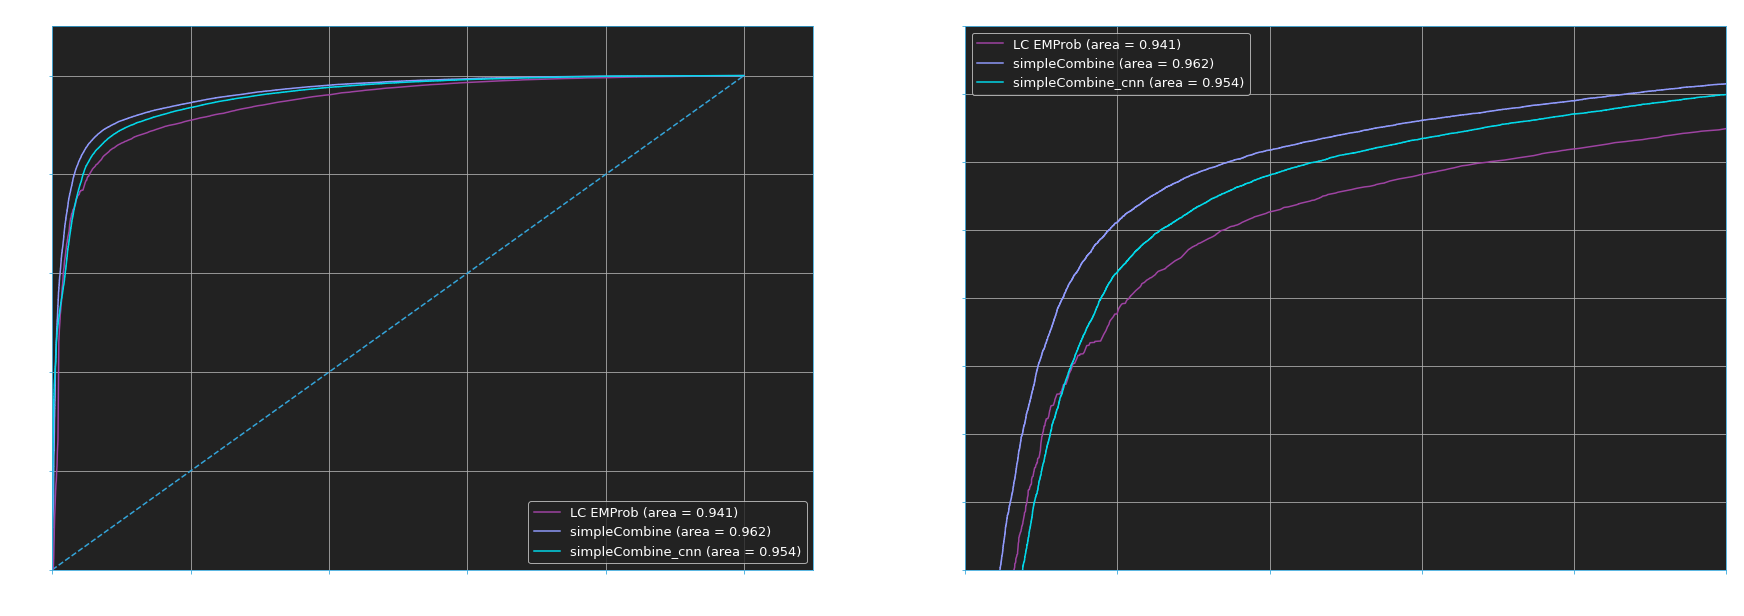

In [19]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    plotstyle=plotstyle,
    model_keys = ['simpleCombine_cnn']
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_simple_cnn',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = ['LC EMProb', 'simpleCombine', 'simpleCombine_cnn']
)

## Convolutional Neural Networks: More complicated architectures
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
We can also consider more complex CNN's.

### 3 EMB layers, separate
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
First, we can try one that uses all three EMB layers as input.

In [20]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=True)
# keep only the EMB layers
pcells_merged_unflattened = {key:pcells_merged_unflattened[key] for key in ['EMB1','EMB2','EMB3']}

rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)

rn_data = {key: list(val.values()) for key,val in rn_data.items()}

In [21]:
model_name = 'cnn'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'cnn_EMB_all'

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 10
augmentation=True
normalization = True # normalize calo images to unit integral

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = emb_cnn_model(
    lr=lr,
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_data['train'], 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_data['valid'], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_data['test'],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

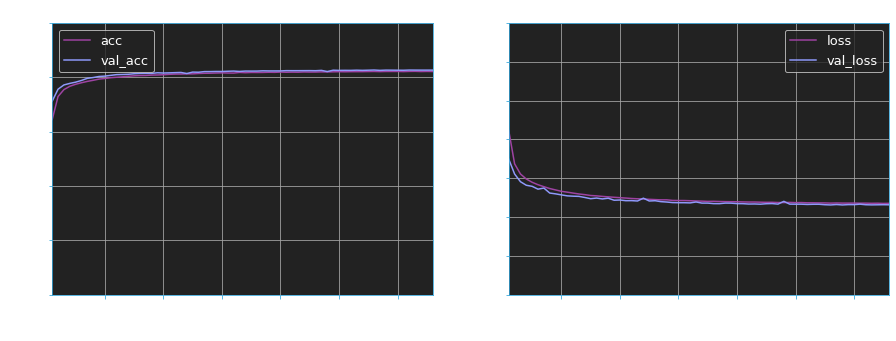

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for simpleCombine_cnn: 0.9543338475
Area under curve for cnn_EMB_all: 0.9661921118055556


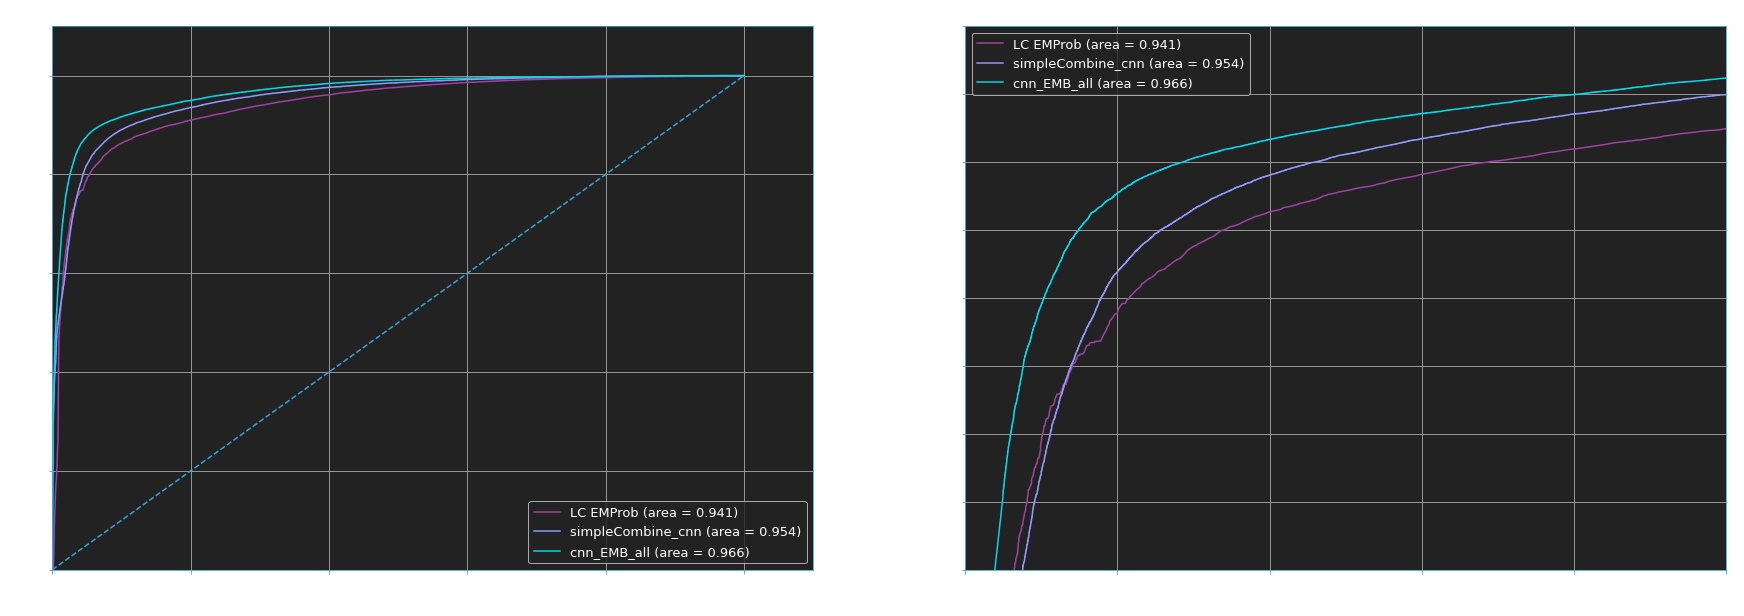

In [22]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['cnn_EMB_all'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_cnn_EMB_all',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'simpleCombine_cnn', 'cnn_EMB_all']
)

### All layers, separate
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
Similarly, we can try a network using all six calo layers, as separate 1-channel images.

In [23]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=True)

rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)

rn_data = {key: list(val.values()) for key,val in rn_data.items()}

In [24]:
model_name = 'cnn'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'cnn_all'

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 10
augmentation=True
normalization = True # normalize calo images to unit integral

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = all_cnn_model(
    lr=lr,
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_data['train'], 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_data['valid'], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_data['test'],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

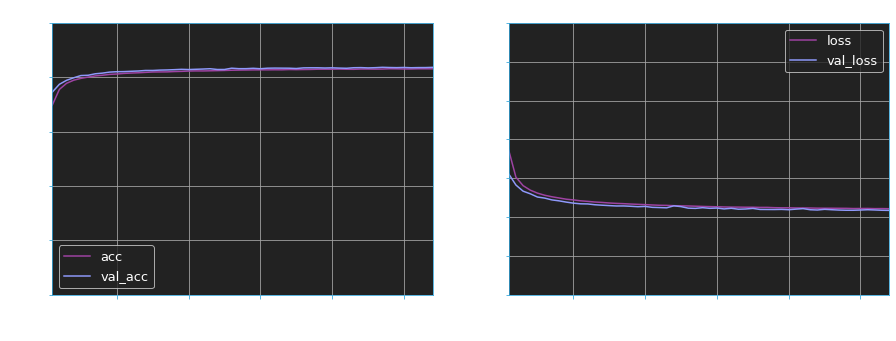

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for simpleCombine_cnn: 0.9543338475
Area under curve for cnn_EMB_all: 0.9661921118055556
Area under curve for cnn_all: 0.9700084456944443


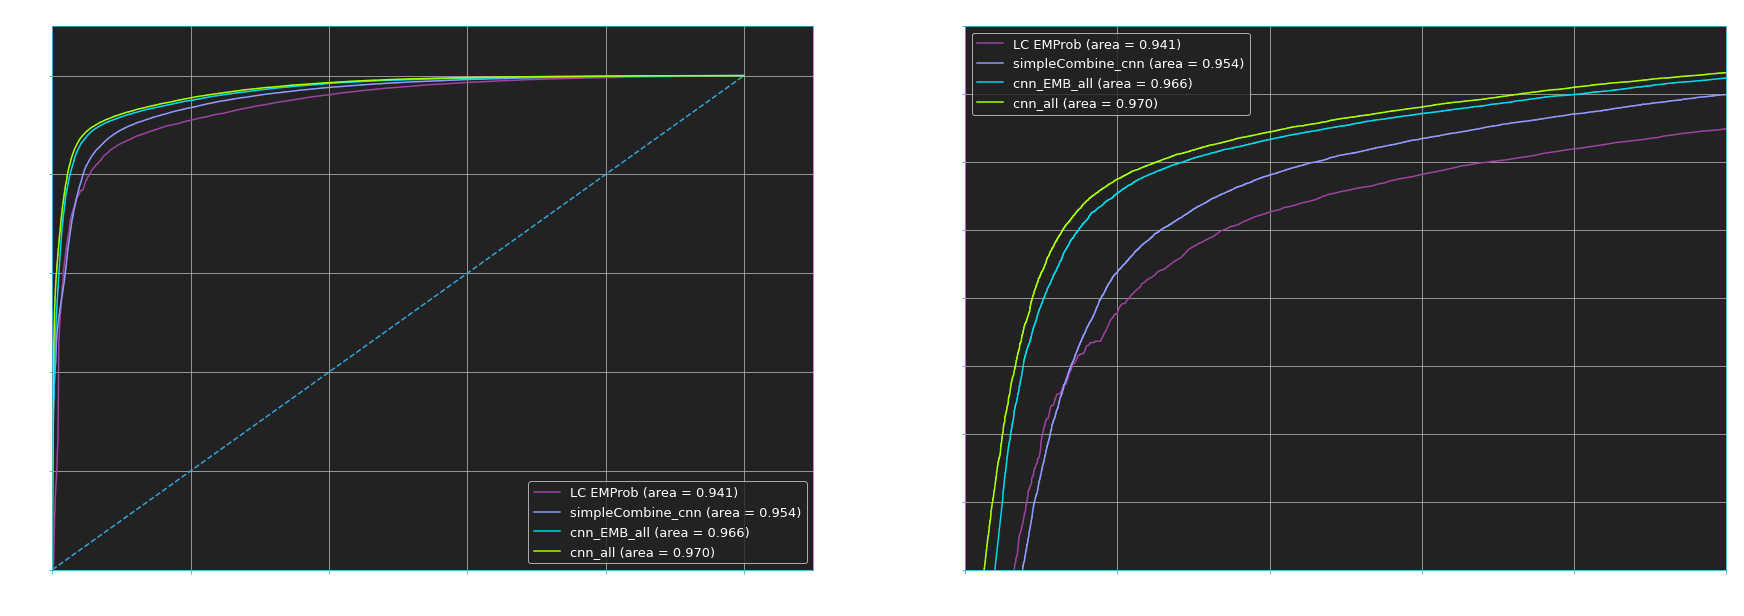

In [25]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['cnn_all'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_cnn_all',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'simpleCombine_cnn', 'cnn_EMB_all', 'cnn_all']
)

### All layers, merged
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
Of course, we can also treat the 6 calo layers as 6 channels of the *same* image. Note that this will require some rescaling of the images so that their dimensions match -- we'll also be careful to preserve their integrals. This last point is probably even more relevant for regression tasks (i.e. predicting energy).

In [26]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=True)
rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)
rn_data = {key: list(val.values()) for key,val in rn_data.items()}

In [27]:
model_name = 'cnn'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'cnn_merged'

input_shape = (16,16)
dropout = 0.2

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 10
augmentation = True
normalization = True # normalize calo images to unit integral

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = merged_cnn_model(
    lr=lr,
    input_shape=input_shape,
    dropout=dropout,
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_data['train'], 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_data['valid'], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_data['test'],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

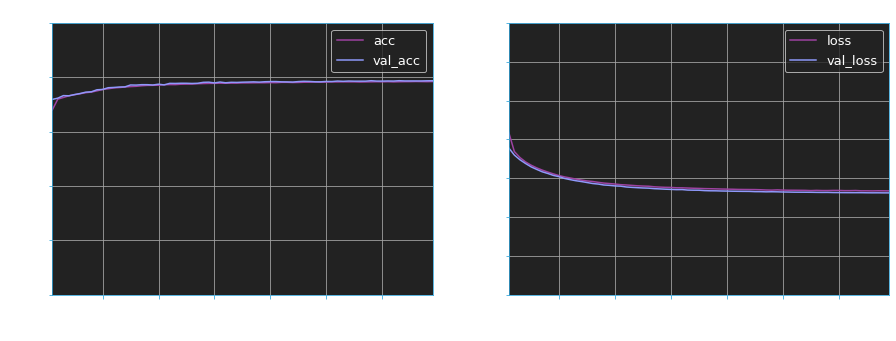

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for simpleCombine_cnn: 0.9543338475
Area under curve for cnn_EMB_all: 0.9661921118055556
Area under curve for cnn_all: 0.9700084456944443
Area under curve for cnn_merged: 0.9564985627777778


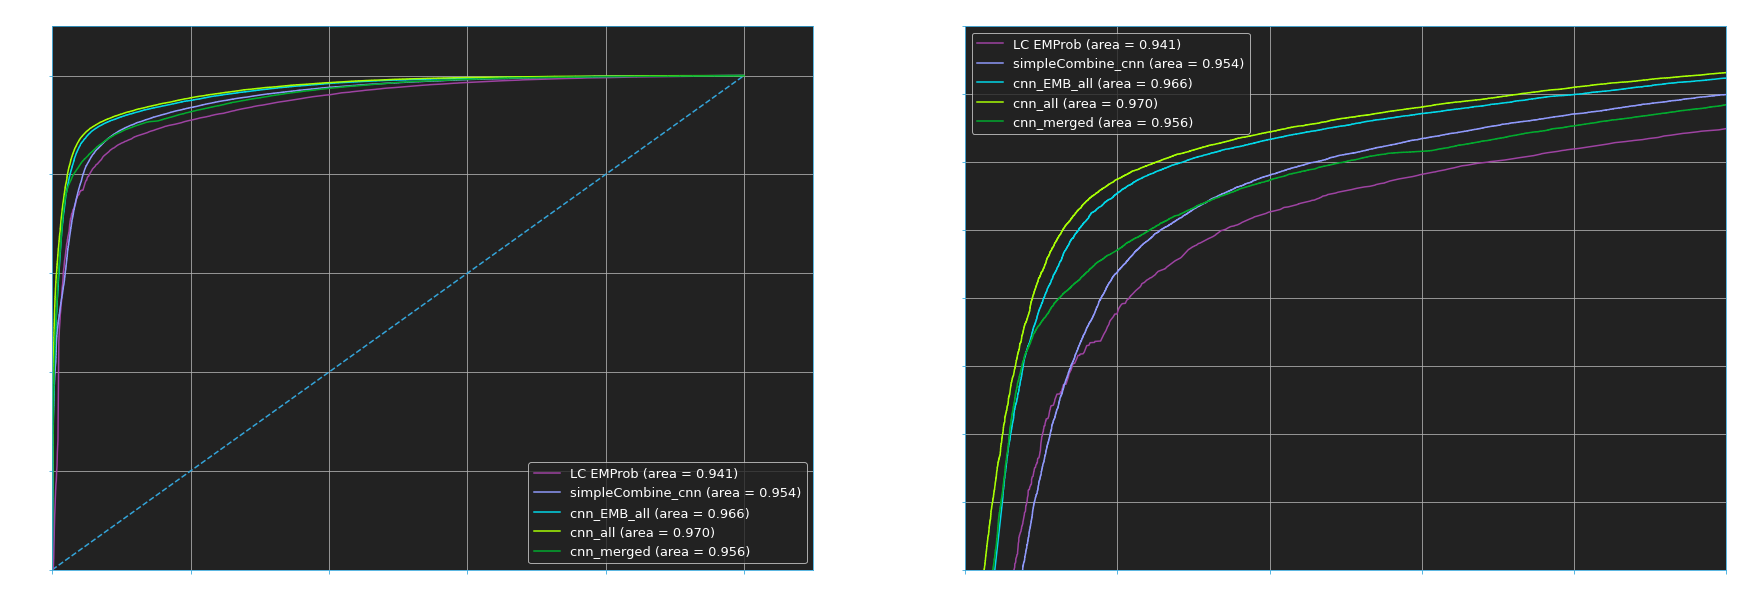

In [28]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['cnn_merged'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_cnn_merged',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'simpleCombine_cnn', 'cnn_EMB_all', 'cnn_all', 'cnn_merged']
)

### EMB merged + TileBar merged
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
As another variation on this theme, we can try a "merged" CNN where we separately treat the 3 EMB layers and the 3 TileBar layers. This will allow us to perform separate rescalings for each -- and we may thus be able to have fewer parameters.

In [29]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=True)
rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)
rn_data = {key: list(val.values()) for key,val in rn_data.items()}

In [30]:
model_name = 'cnn'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'cnn_merged_2p'

input_shape1 = (16,16)
input_shape2 = (4,4)
dropout = 0.2

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 10
augmentation = True
normalization = True # normalize calo images to unit integral

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = merged_cnn_2p_model(
    lr=lr,
    input_shape1=input_shape1,
    input_shape2=input_shape2,
    dropout=dropout,
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_data['train'], 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_data['valid'], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_data['test'],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

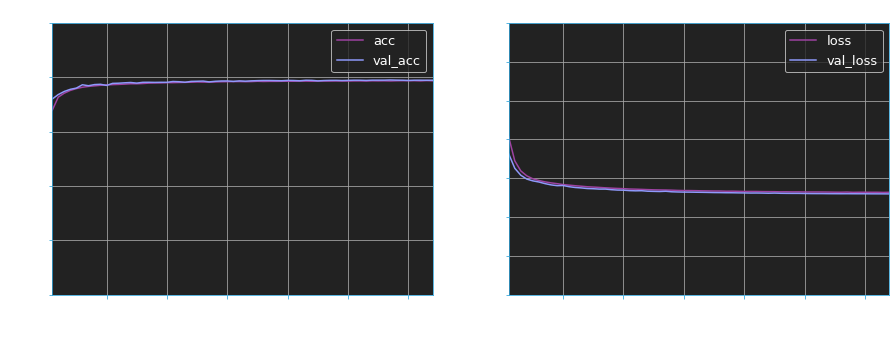

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for cnn_merged: 0.9564985627777778
Area under curve for cnn_merged_2p: 0.9570847931944445


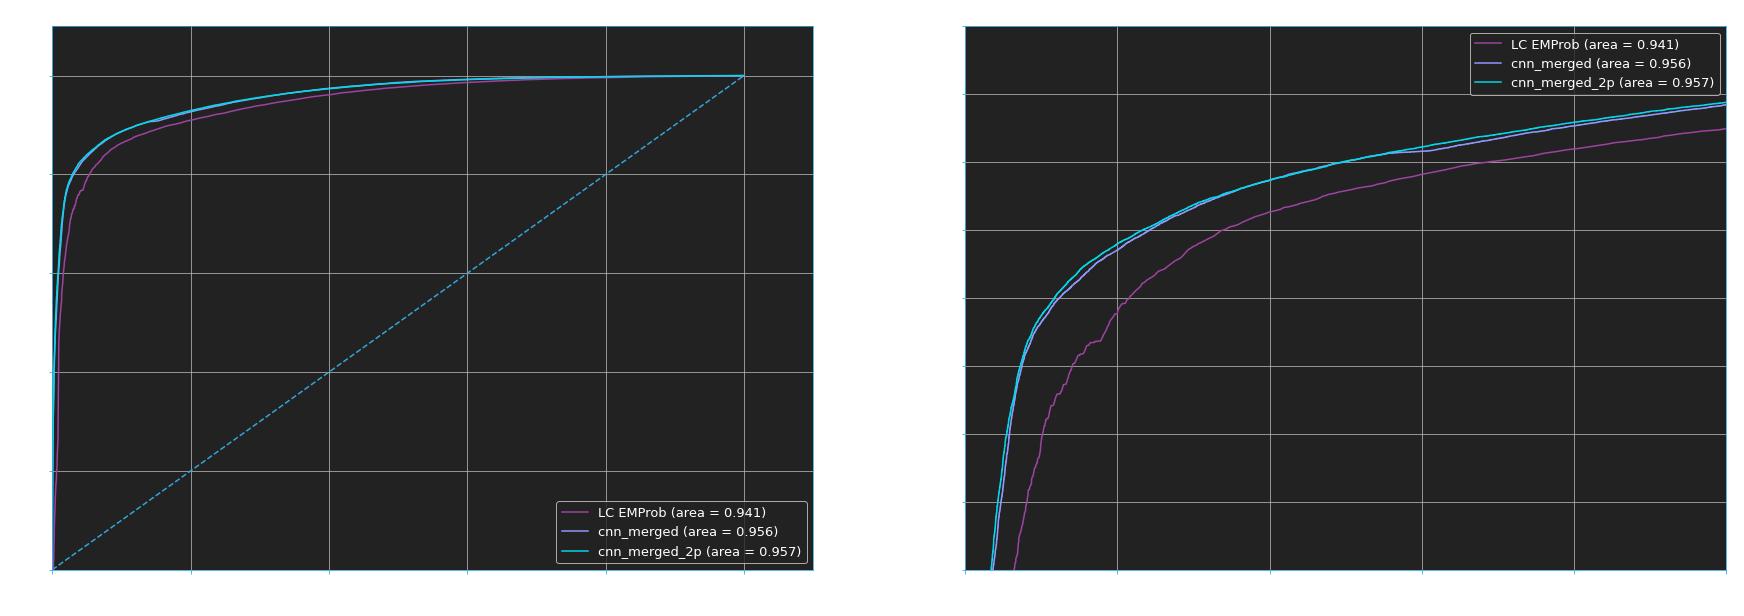

In [31]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['cnn_merged_2p'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_cnn_merged_2p',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'cnn_merged', 'cnn_merged_2p']
)

### EMB merged + TileBar depth
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
As an experiment, we can try a network where we use a CNN approach for the EMB layers, whereas for TileBar we just use the integrals of the 3 Tilebar layers. In other words, we don't fully use TileBar images, but just get some depth info from how populated they are.

In [32]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=True)
rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)
rn_data = {key: list(val.values()) for key,val in rn_data.items()}

In [33]:
model_name = 'cnn'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'cnn_exp'

input_shape = (16,16)
dropout = 0.2

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 10
augmentation = True
normalization = True # normalize calo images to unit integral

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = exp_cnn_model(
    lr=lr,
    input_shape=input_shape,
    dropout=dropout,
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_data['train'], 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_data['valid'], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_data['test'],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

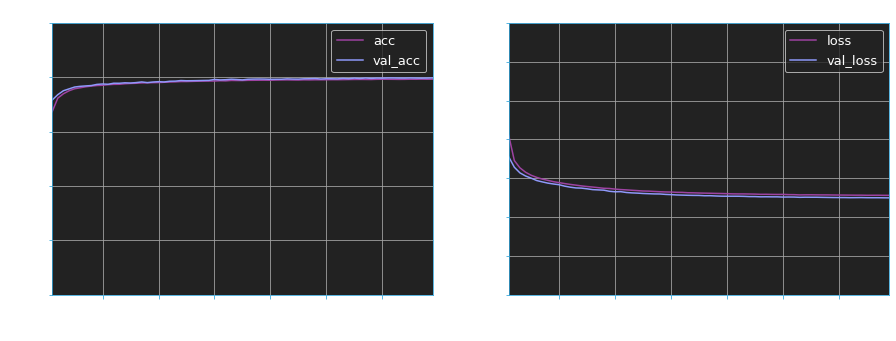

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for cnn_merged: 0.9564985627777778
Area under curve for cnn_merged_2p: 0.9570847931944445
Area under curve for cnn_exp: 0.9603994334722222


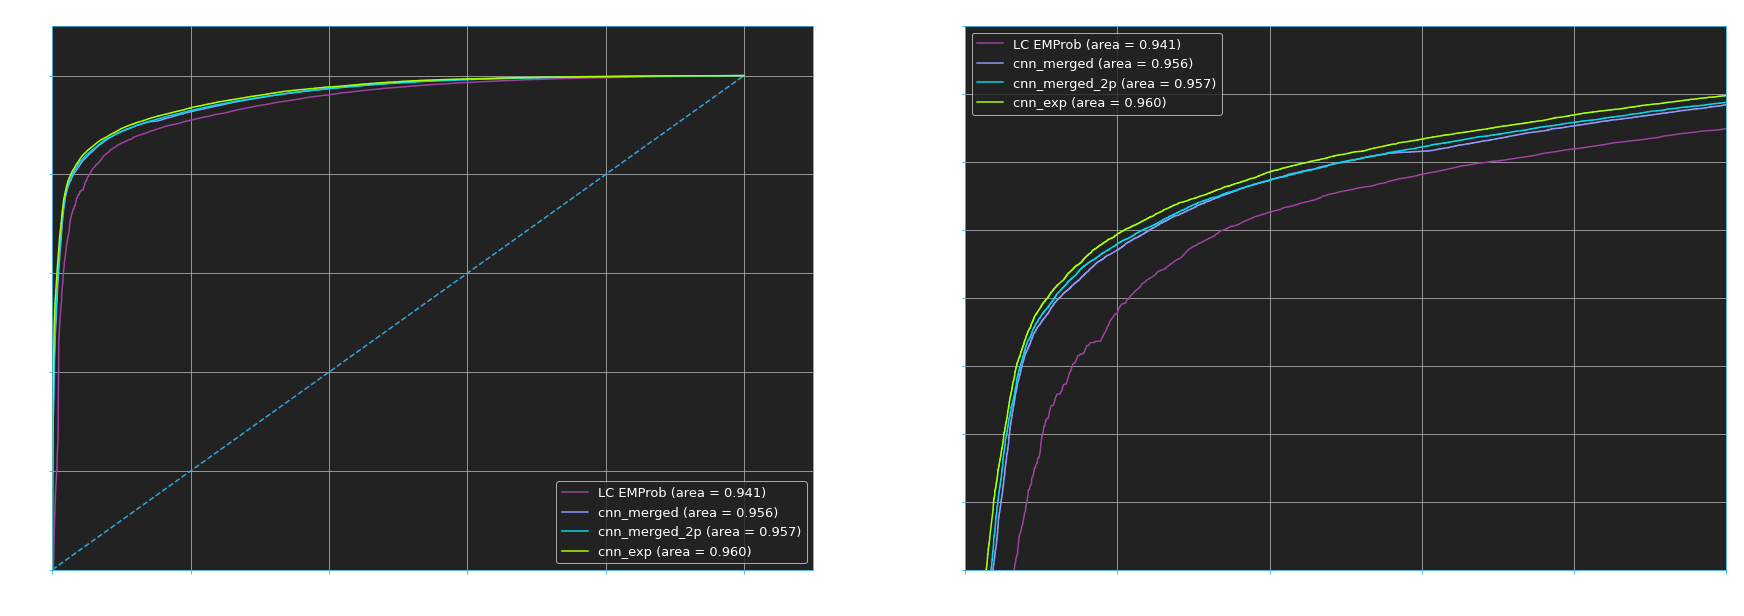

In [34]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['cnn_exp'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_cnn_exp',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'cnn_merged', 'cnn_merged_2p', 'cnn_exp']
)

### EMB1, EMB2+EMB3, and TileBar
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
As another experiment, we can try a network where we use a CNN approach for all layers, but we combine things a little differently. Rather than combine all EMB and all TileBar layers, we separate EMB into EMB1, and (EMB2 + EMB3).

In [35]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=True)
rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)
rn_data = {key: list(val.values()) for key,val in rn_data.items()}

In [36]:
model_name = 'cnn'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'cnn_split_EMB'

dropout = 0.2

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 10
augmentation = False
normalization = True # normalize calo images to unit integral

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = exp_merged_model(
    lr=lr,
    dropout=dropout,
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_data['train'], 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_data['valid'], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_data['test'],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

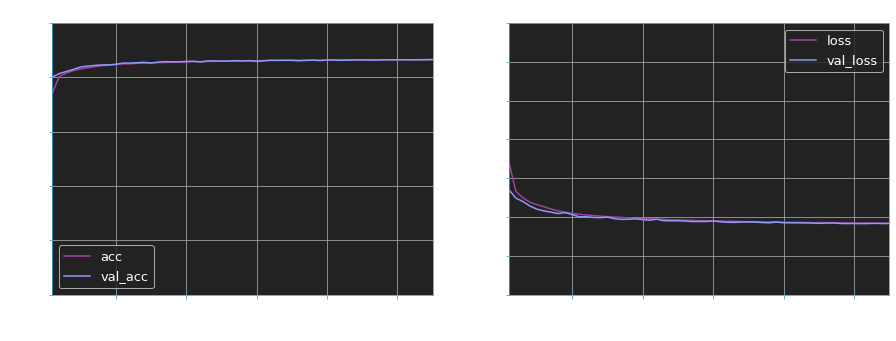

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for cnn_merged: 0.9564985627777778
Area under curve for cnn_merged_2p: 0.9570847931944445
Area under curve for cnn_exp: 0.9603994334722222
Area under curve for cnn_split_EMB: 0.9786880391666666


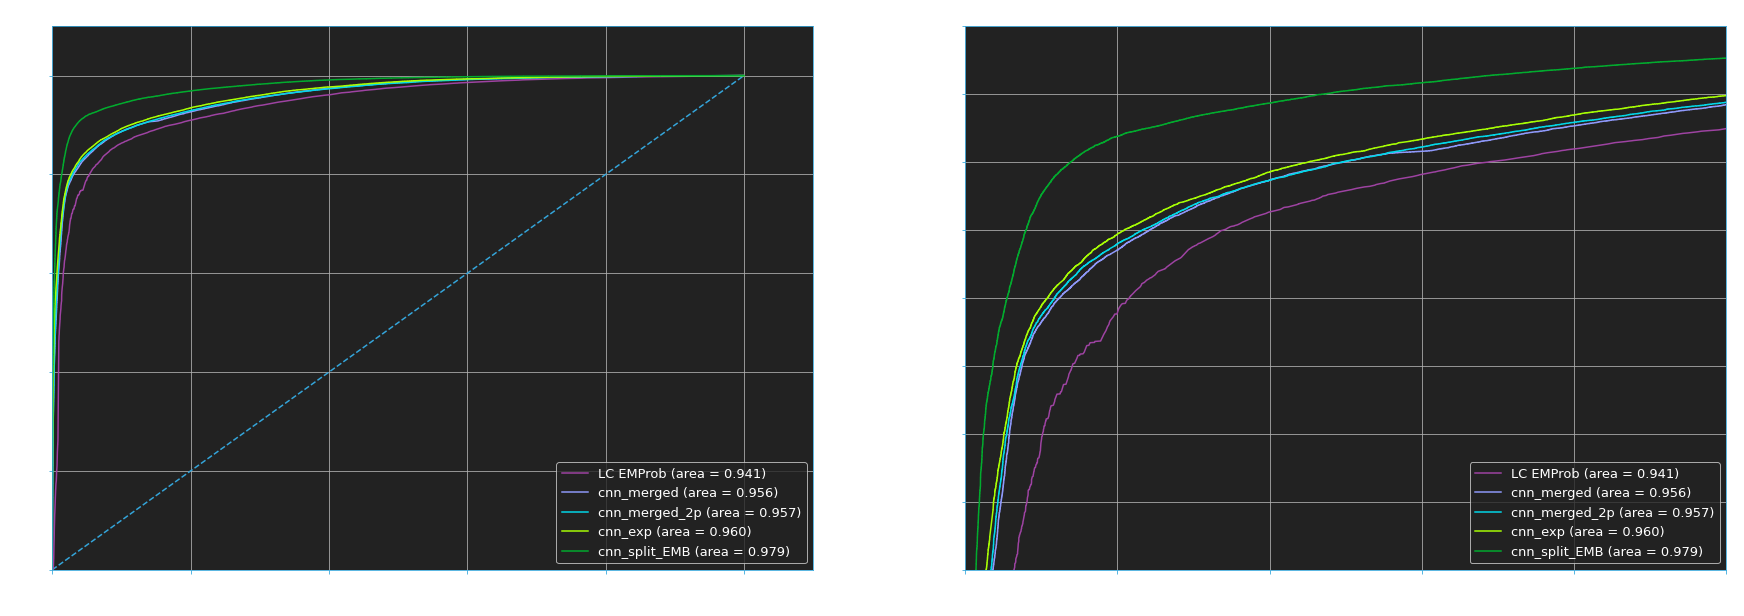

In [37]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['cnn_split_EMB'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_cnn_split_EMB',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'cnn_merged', 'cnn_merged_2p', 'cnn_exp', 'cnn_split_EMB']
)

## ResNet
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
We can also train an instance of ResNet. As with our multi-layer CNN's, we'll need to perform some up/downscaling of images, so that they all have the same dimensions. As we did for some of our CNN's, we will use the maximum possible granularity, `(128,16)` (corresponding with maximum eta and phi dimensions among all calo layers).

In [38]:
pcells_merged_unflattened = cdu.ReshapeImages(pcells_merged, cell_shapes, use_layer_names=False)
rn_data = cdu.DictionarySplit(
    pcells_merged_unflattened, 
    train_indices=pdata_merged.train,
    validation_indices = pdata_merged.val,
    test_indices = pdata_merged.test
)

We can run a quick test to make sure that our image scaling is working as expected.

In [39]:
image_test=False

from util.keras.layers import ImageScaleBlock
def TestImage(idxs):
    images = [np.stack([rn_train['input{}'.format(x)][idx,:,:] for idx in idxs],axis=0) for x in range(6)]    
    # need to add the last dimension, corresponding with channel (will be of size 1)
    images = [np.expand_dims(im, axis=-1) for im in images]
    return images

if(image_test):
    test_idx = np.arange(5)
    image = TestImage(test_idx)
    scaled_image = ImageScaleBlock((128,16),normalization=True)(image).numpy()
    for i,im in enumerate(image):
        integrals_old = np.sum(im,axis=(1,2)).flatten()
        integrals_new = np.sum(scaled_image[:,:,:,i], axis=(1,2)).flatten()

        ratio = integrals_old.copy()
        ratio[ratio==0.] = 1.
        ratio = integrals_new/ratio

        integrals_old = '\t\t'.join(['{:.1e}'.format(x) for x in integrals_old])
        integrals_new = '\t\t'.join(['{:.1e}'.format(x) for x in integrals_new])
        ratio         = '\t\t'.join(['{:.1e}'.format(x) for x in ratio        ])

        print('Integral {} = {}'.format(i,integrals_old))
        print('           = {}'.format(integrals_new))
        print('Ratios     = {}'.format(ratio))
        print()

In [40]:
#tf.keras.backend.set_image_data_format('channels_last')
model_name = 'resnet'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'resnet'

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 20 # large patience since loss sometimes fluctuates upwards for a bit?
input_shape = (128,16)
channels = 6
augmentation=True
normalization = True
filter_sets = [
    [64,64,256],
    [128,128,512]
    #[256,256,1024],
    #[512,512,2048]
]         
f_vals = [3,3] # [3,3,3,3] sizes of filters in middle of conv/identity blocks
s_vals = [1,2] # [1,2,2,2] strides for each convolutional block
i_vals = [2,3] # [2,3,5,2] number of identity blocks per stage

nepochs = 200
batch_size = 50 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = resnet(
    filter_sets=filter_sets, 
    lr=lr, 
    channels=channels, 
    f_vals=f_vals, 
    s_vals=s_vals, 
    i_vals=i_vals, 
    input_shape=input_shape, 
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_data['train'], 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_data['valid'], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_data['test'],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

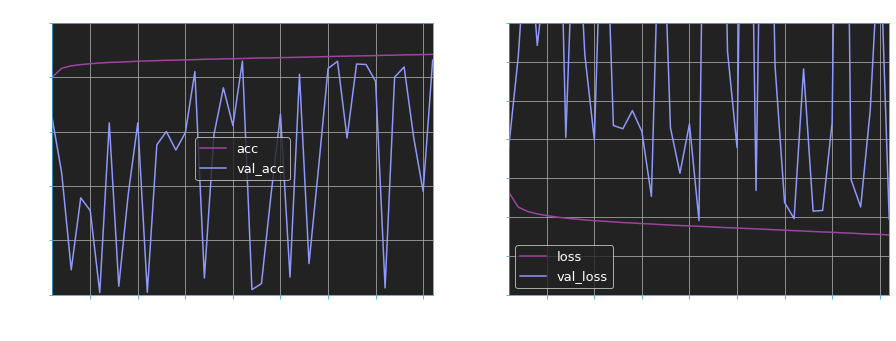

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for flat_EMB1: 0.9523438956944446
Area under curve for resnet: 0.9769413697222222


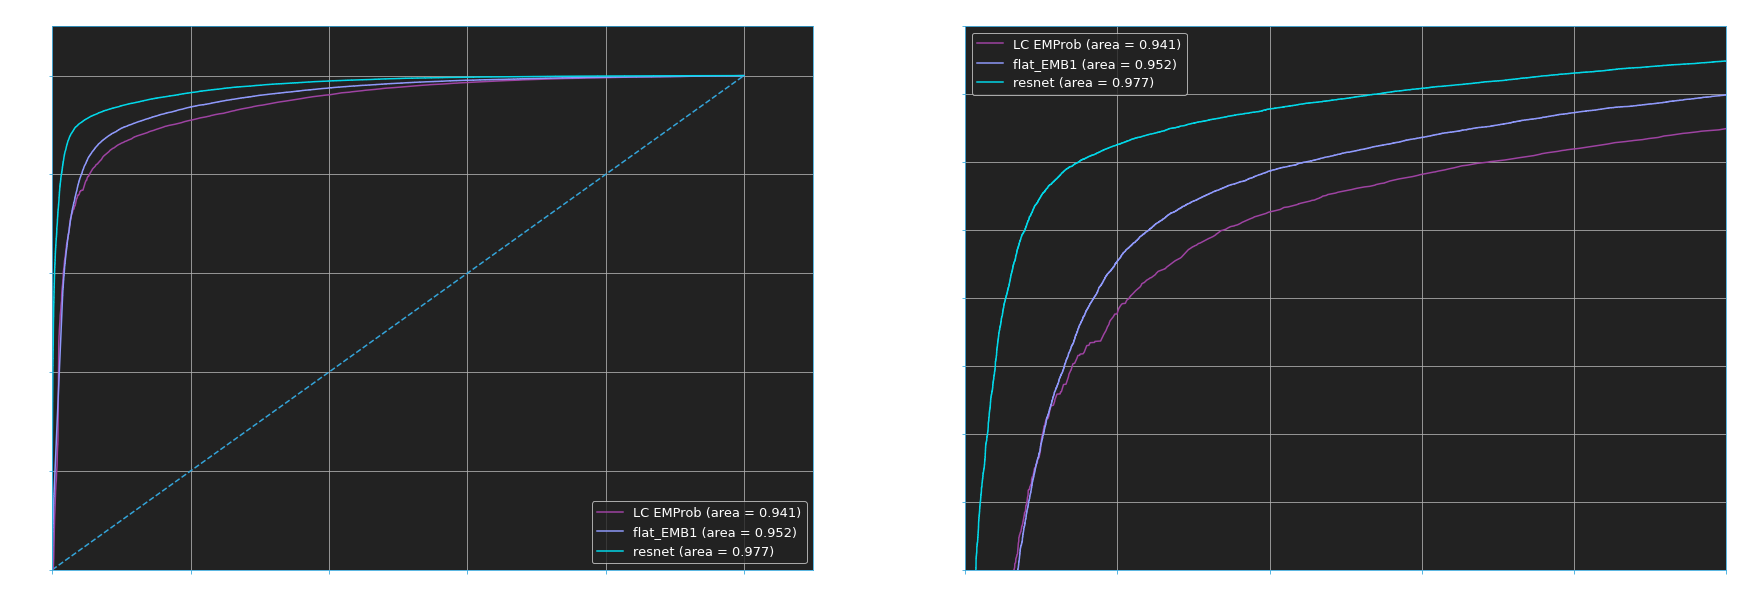

In [41]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['resnet'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_resnet',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'flat_EMB1', 'resnet']
)

## Combination Network: Take 3
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>
For fun, we can also train a combination network where we use our flat DNN's, and ResNet as an additional input.

In [42]:
model_scores_stack = np.column_stack( [model_scores['flat_{}'.format(layer)] for layer in layers])
model_scores_stack = np.column_stack((model_scores_stack, model_scores['resnet']))
n_input = model_scores_stack.shape[1]

nepochs = 50
batch_size = 200*ngpu
verbose = 2


model_name = 'simple_resnet'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'simpleCombine_resnet'

lr = 1e-3
gamma = 0.1
min_delta = 0.001
patience = 5

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = simple_combine_model(strategy, lr=lr, n_input=n_input)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = model_scores_stack[pdata_merged.train],
    y_train = plabels[pdata_merged.train], 
    x_valid = model_scores_stack[pdata_merged.val], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    model_scores_stack[pdata_merged.test],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(model_scores_stack)[:,1]

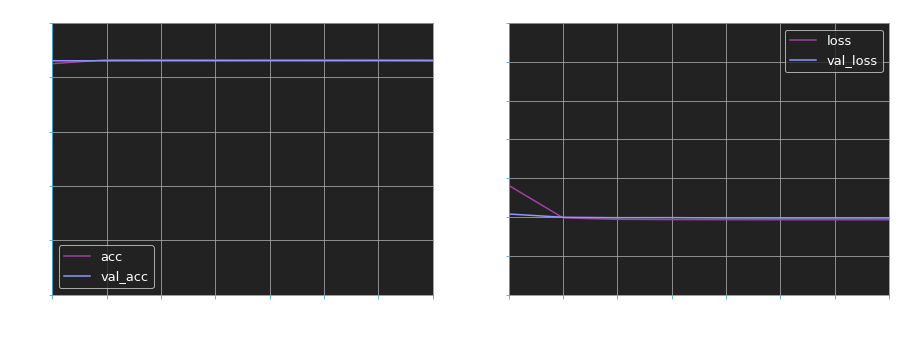

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for simpleCombine: 0.9616348475
Area under curve for resnet: 0.9769413697222222
Area under curve for simpleCombine_cnn: 0.9543338475
Area under curve for simpleCombine_resnet: 0.9750073005555556


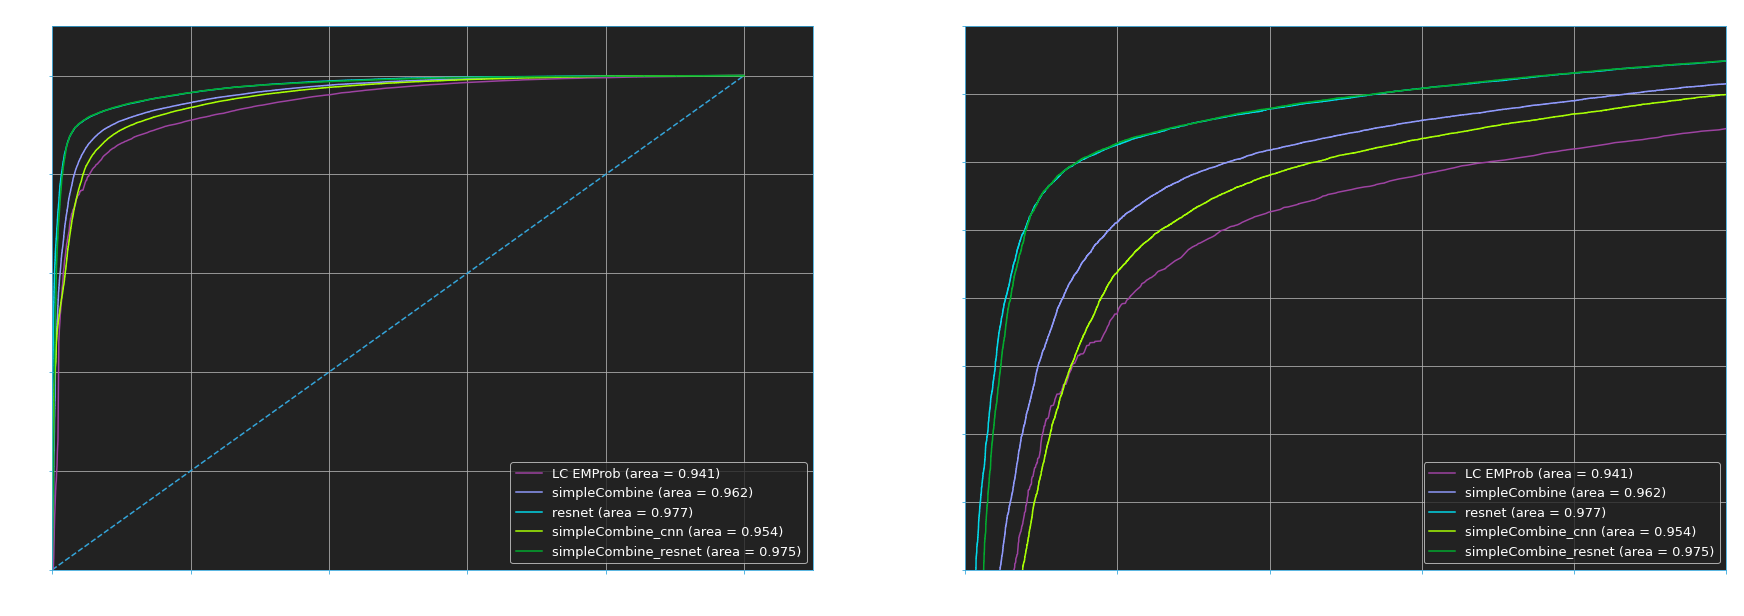

In [43]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys = ['simpleCombine_resnet'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_simple_resnet',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = ['LC EMProb', 'simpleCombine', 'resnet', 'simpleCombine_cnn', 'simpleCombine_resnet']
)

## Summary Plots
<div style="text-align: right"> <a href="#Quick-Navigation:">Top</a> </div>

After we've trained networks to our hearts' content, we can make a set of ROC curves to summarize our results.

In [75]:
draw_keys_default = ['LC EMProb','flat_EMB1', 'simpleCombine', 'cnn_EMB_all', 'cnn_all', 'cnn_merged', 'cnn_split_EMB', 'resnet']
draw_cols_default = [plotstyle.colors[(i) % (len(plotstyle.colors)-1)] for i in range(len(draw_keys_default))]

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for flat_EMB1: 0.9523438956944446
Area under curve for flat_EMB2: 0.87490145
Area under curve for flat_EMB3: 0.7975528063888888
Area under curve for cnn_EMB1: 0.9431524611111113
Area under curve for cnn_EMB2: 0.8210821644444446
Area under curve for cnn_EMB3: 0.8017951770833334
Area under curve for simpleCombine: 0.9616348475
Area under curve for simpleCombine_cnn: 0.9543338475
Area under curve for cnn_EMB_all: 0.9661921118055556
Area under curve for cnn_all: 0.9700084456944443
Area under curve for cnn_merged: 0.9564985627777778
Area under curve for cnn_split_EMB: 0.9786880391666666
Area under curve for resnet: 0.9769413697222222
Area under curve for simpleCombine_resnet: 0.9750073005555556


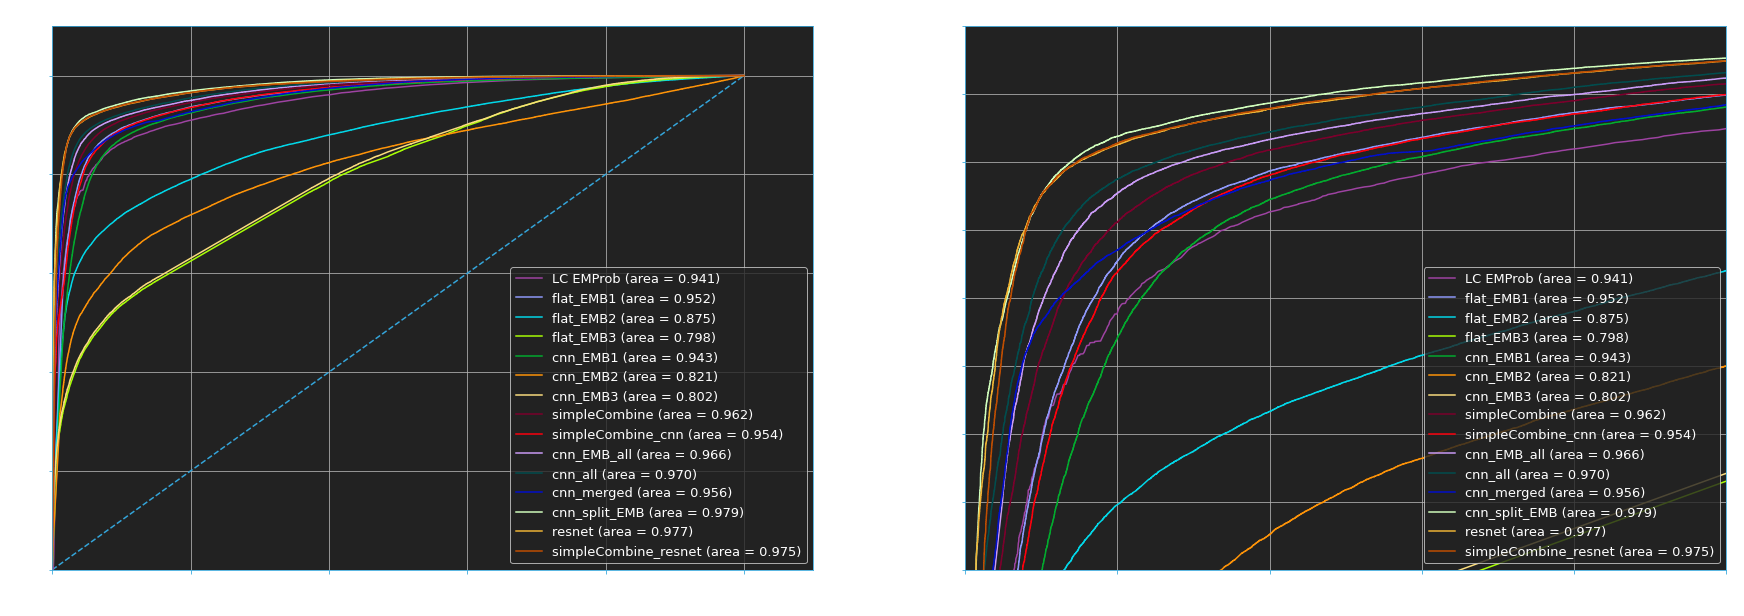

Area under curve for LC EMProb: 0.9408900906944444
Area under curve for flat_EMB1: 0.9523438956944446
Area under curve for simpleCombine_cnn: 0.9543338475
Area under curve for simpleCombine: 0.9616348475
Area under curve for cnn_EMB_all: 0.9661921118055556
Area under curve for cnn_all: 0.9700084456944443
Area under curve for cnn_merged: 0.9564985627777778
Area under curve for resnet: 0.9769413697222222
Area under curve for simpleCombine_resnet: 0.9750073005555556


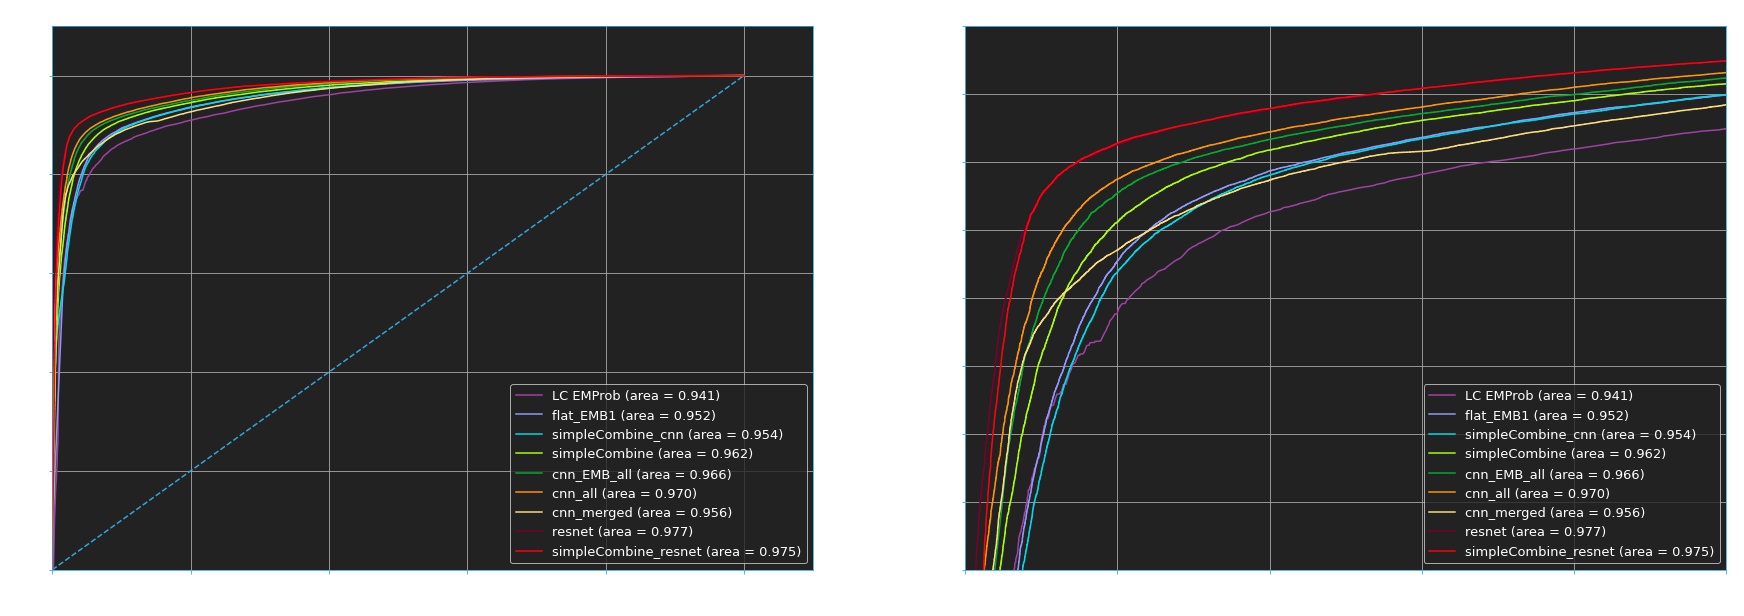

In [44]:
cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_summary',
    drawPlots=True,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = ['LC EMProb', 'flat_EMB1', 'flat_EMB2', 'flat_EMB3', 'cnn_EMB1', 'cnn_EMB2', 'cnn_EMB3', 'simpleCombine', 'simpleCombine_cnn', 'cnn_EMB_all', 'cnn_all', 'cnn_merged', 'cnn_split_EMB', 'resnet', 'simpleCombine_resnet']
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_best',
    drawPlots=True,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = draw_keys_default
)

Let's also make a scatterplot of number of learnable parameters versus accuracy. The number of parameters can be thought of as a stand-in for complexity (though I assume that computational complexity/cost will also depend on the exact operations being performed).

Note that there is some inherent hard-coding being done here, since some of our models (e.g. `simpleCombine`) use other models as input -- and for such models, we want to count their inputs' weights plus their own.

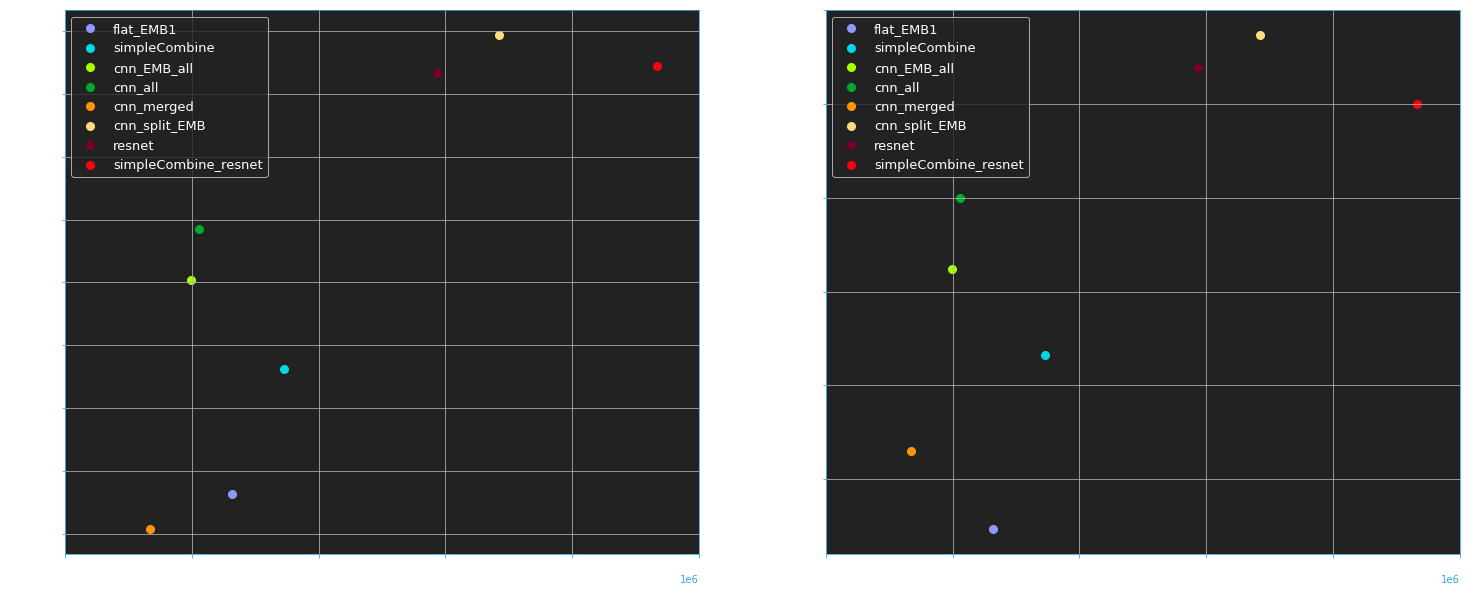

In [76]:
import tensorflow.keras.backend as K

complexity_scatter = {}

for key, model in models.items():
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    accuracy        = model_performance[key][1]
    auc             = roc_auc[key]
    complexity_scatter[key] = [trainable_count, accuracy, auc]
    
# manually adjust complexity_scatter for our combination networks
flat_weights = np.sum([np.sum([K.count_params(w) for w in models[key].trainable_weights]) for key in ['flat_{}'.format(layer) for layer in layers]])
cnn_weights = np.sum([np.sum([K.count_params(w) for w in models[key].trainable_weights]) for key in ['cnn_{}'.format(layer) for layer in layers]])
complexity_scatter['simpleCombine'][0] += flat_weights
complexity_scatter['simpleCombine_cnn'][0] += cnn_weights
complexity_scatter['simpleCombine_resnet'][0] += flat_weights + complexity_scatter['resnet'][0]
    
fig, ax = plt.subplots(1,2, figsize=(25,10))
for axis in ax: plotstyle.SetStylePlt(axis)

# Make a scatter -- there will be a lot of points, so consider not drawing them for each network.
draw_keys = draw_keys_default[1:]
draw_cols = draw_cols_default[1:]

for i,key in enumerate(draw_keys):
    if(key not in complexity_scatter.keys()): continue
    x,y1,y2 = complexity_scatter[key]
    ax[0].scatter(x=x,y=y1, label=key, color=draw_cols[i], s=64)
    ax[1].scatter(x=x,y=y2, label=key, color=draw_cols[i], s=64)
    
    ax[0].set_xlabel('# Learnable Parameters')
    ax[1].set_xlabel('# Learnable Parameters')
    
    ax[0].set_ylabel('Accuracy')
    ax[1].set_ylabel('Area under ROC curve')
    
    ax[0].set_xlim([0.,2.5e6])
    ax[1].set_xlim([0.,2.5e6])
    
    ax[0].set_ylim([0.88,1.0])
    ax[1].set_ylim([0.95,1.0])

legs = []
for i,axis in enumerate(ax):
    legs.append(axis.legend(facecolor=plotstyle.canv_plt))
    for leg_text in legs[-1].get_texts(): leg_text.set_color(plotstyle.text_plt)
        
qu.SaveSubplots(fig, ax, ['acc_params', 'auc_params'], savedir=plotpath, ps=plotstyle)

From these plots, `cnn_all` looks like a relatively appealing option -- it's one of the highest-performing networks, and it actually has the fewest learnable parameters. `resnet` performs slightly better, but at the cost of many more learnable weights. This added complexity may translate to slower deployment time, and cause issues if we try to use this network in a triggering context (i.e. on an FPGA), where we will have to deal with significant hardware and timing constraints.

It would be nice to also make a table (or plot) depicting the false positive rate at different true positive rate (i.e. pick out a few reference points from the ROC curves).

In [46]:
from scipy.interpolate import interp1d

In [47]:
fpr_data = {}
tpr_vals = np.array([0.6,0.8,0.9,0.95])

for tpr_val in tpr_vals: 
    fpr_data[tpr_val] = {}
    for i, key in enumerate(roc_fpr.keys()):
        
        # Want to find the fpr at the given tpr
        fpr = roc_fpr[key]
        tpr = roc_tpr[key]
        f = interp1d(tpr, fpr)        
        fpr_data[tpr_val][key] = f(tpr_val)

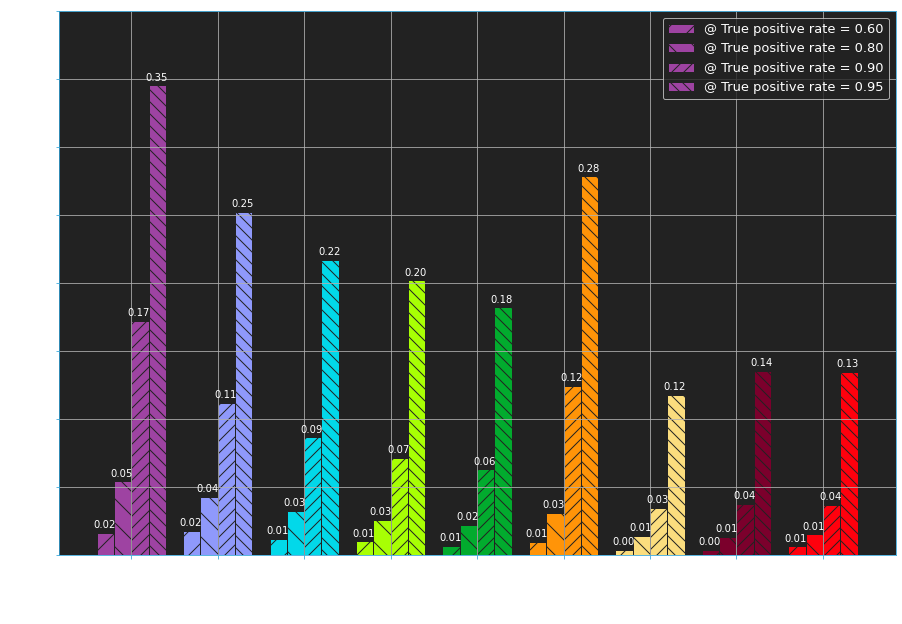

In [128]:
draw_keys = draw_keys_default
draw_cols = draw_cols_default

fig, ax = plt.subplots(figsize=(15,10))
plotstyle.SetStylePlt(ax)

# multiple bars -- handle visual offsets
bar_width = 0.2
n = len(draw_keys)
k = len(fpr_data.keys())
offsets = np.linspace(0., (k-1) * bar_width, k)
offsets = offsets - np.mean(offsets)

# hatches for distinguishing between different tpr values
hatches = ['/','\\','//','\\\\']

x = np.arange(n)
rects = []
for i,tpr_val in enumerate(fpr_data.keys()):
    vals = [fpr_data[tpr_val][a] for a in draw_keys]
    bar = ax.bar(
        x + offsets[i], 
        vals,
        bar_width,
        label='@ True positive rate = {:.2f}'.format(tpr_val), 
        color=draw_cols,
        hatch = hatches[i],
        edgecolor=plotstyle.canv_plt
    )
    
    for rect in bar:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(-1, 3),  # 1 point horizontal offset, 3 points vertical offset
            textcoords="offset points",
            color=plotstyle.text_plt,
            ha='center', va='bottom'
                   )
    rects.append(bar)

result = ax.set_xticks(x)
x_labels = [x.replace('_','\n') for x in draw_keys]
result = ax.set_xticklabels(x_labels)

ax.set_xlabel('Method')
ax.set_ylabel('False positive rate')
ax.set_ylim(0.,0.4)

leg = ax.legend(facecolor=plotstyle.canv_plt)
for leg_text in leg.get_texts(): leg_text.set_color(plotstyle.text_plt)
    
qu.SaveSubplots(fig, np.array([ax]), ['fpr'], savedir=plotpath, ps=plotstyle)

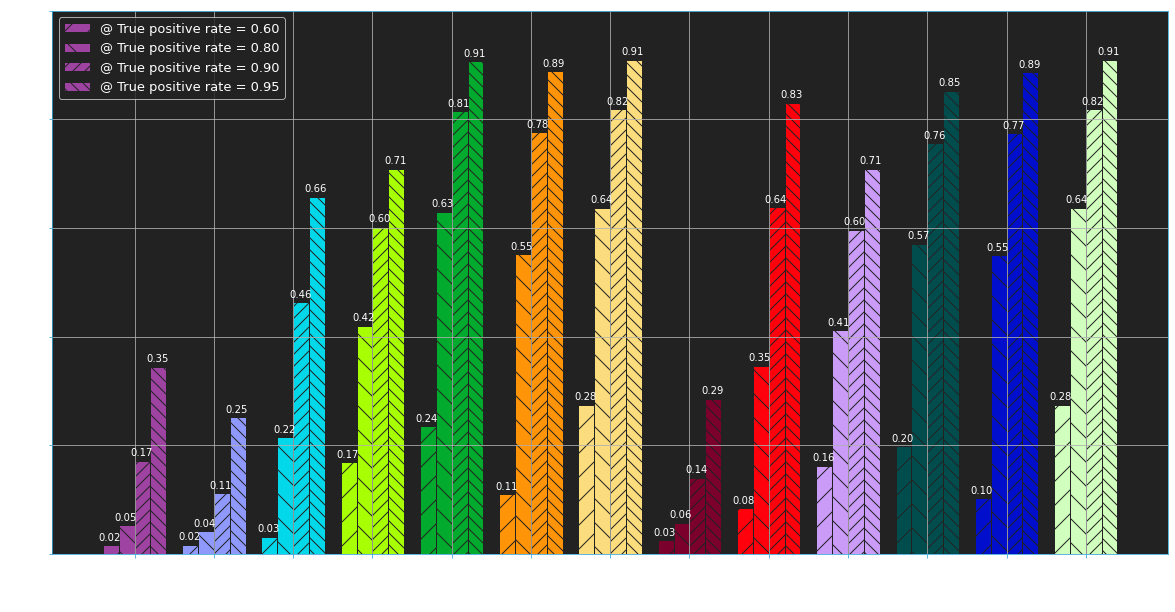

In [127]:
draw_keys = ['LC EMProb'] + ['flat_{}'.format(x) for x in layers] + ['cnn_{}'.format(x) for x in layers]
draw_cols = [plotstyle.colors[(i) % (len(plotstyle.colors)-1)] for i in range(len(draw_keys))]

fig, ax = plt.subplots(figsize=(20,10))
plotstyle.SetStylePlt(ax)

# multiple bars -- handle visual offsets
bar_width = 0.2
n = len(draw_keys)
k = len(fpr_data.keys())
offsets = np.linspace(0., (k-1) * bar_width, k)
offsets = offsets - np.mean(offsets)

# hatches for distinguishing between different tpr values
hatches = ['/','\\','//','\\\\']

x = np.arange(n)
rects = []
for i,tpr_val in enumerate(fpr_data.keys()):
    vals = [fpr_data[tpr_val][a] for a in draw_keys]
    bar = ax.bar(
        x + offsets[i], 
        vals,
        bar_width,
        label='@ True positive rate = {:.2f}'.format(tpr_val), 
        color=draw_cols,
        hatch = hatches[i],
        edgecolor=plotstyle.canv_plt
    )
    
    for rect in bar:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(-1, 3),  # 1 point horizontal offset, 3 points vertical offset
            textcoords="offset points",
            color=plotstyle.text_plt,
            ha='center', va='bottom'
                   )
    rects.append(bar)

result = ax.set_xticks(x)
x_labels = [x.replace('_','\n') for x in draw_keys]
result = ax.set_xticklabels(x_labels)

ax.set_xlabel('Method')
ax.set_ylabel('False positive rate')
ax.set_ylim(0.,1.0)

leg = ax.legend(facecolor=plotstyle.canv_plt)
for leg_text in leg.get_texts(): leg_text.set_color(plotstyle.text_plt)
    
qu.SaveSubplots(fig, np.array([ax]), ['fpr_single'], savedir=plotpath, ps=plotstyle)